In [426]:
%load_ext nb_mypy
%nb_mypy Off

The nb_mypy extension is already loaded. To reload it, use:
  %reload_ext nb_mypy


In [427]:
from __future__ import annotations
import numpy as np
import random
import copy
import importlib

from typing import Tuple, List
from numpy import array, zeros

# from Big_Class import Big_Class  # already imported one NETfuncs is imported
from User_Variables import User_Variables  # already imported one NETfuncs is imported
from Network_Structure import Network_Structure  # already imported one NETfuncs is imported
from Big_Class import Big_Class
from Network_State import Network_State
from Networkx_Net import Networkx_Net
import matrix_functions, functions, statistics, plot_functions, solve, figure_plots

## Set up Network

In [428]:
## Parameters

## task type
# task_type='Iris_classification'
task_type='Regression'

## task matrix X
M_values: np.ndarray = array([0.15, 0.2, 0.25, 0.1, 0.02, 0.3, 0.35, 0.15, 0.03, 0.25, 0.1, 0.15, 0.02, 0.3, 0.35, 0.15, 0.03])
# M_values: np.ndarray = array([0.5, 0., 0., 0.1])

## specify # of nodes
Nin: int = 2
extraNin: int = 0
Ninter: int = 0
Nout: int = 1
extraNout: int = 0

# learning rate
# alpha_vec = np.array([0.2, 0.5, 1.0, 2.0, 2.5, 2.7, 3.5, 4.0, 8.0])  # 1D array = const alpha, array of arrays = annealed
# alpha_vec = np.array([np.append(np.linspace(4.1,4.8,200), np.linspace(4.8,4.1,200))])  # 1D array for constant alpha, array of arrays for annealed alpha
# alpha_vec: np.ndarray = np.array([0.2])  # for allostery, regression and general_reg
# alpha_vec = np.array([0.1])  # for general_reg_allRsChange
# alpha_vec = np.array([np.linspace(5,3.85,40)])  # 1D array for constant alpha, array of arrays for annealed alpha
# alpha_vec = np.array([4.8])
alpha: float = 1.0  # for network combine attempt

# resistance-pressure proportionality factor
gamma: np.ndarray = np.array([1.0])

## method to update resistances - physical property of the system
# R_update: str = 'R_propto_dp'
R_update: str = 'deltaR_propto_dp'
# R_update: str = 'R_propto_Q'
# R_update: str = 'deltaR_propto_Q'
# R_update: str = 'deltaR_propto_Power'
# R_vec_i = array([1.9, 1., 0.85, 1.05, 0.9, 1., 0.85, 1.05, 0.9, 3., 0.85, 1.05, 0.9, 1., 0.85, 1.05, 1., 2.95, 0.55])
# R_vec_i = array([3.74, 3.16, 1.38, -7.07, -3.01, 1.40, 1., 1., 1., 1., 1.])  # regression using 2in3out, M values [0.15, 0.2, 0.25, 0.1, 0.02, 0.3]
R_vec_i = 2*np.ones(Nin*Nout + Nin + Nout)

# length of training dataset
iterations = 18000  # number of sampled of p

# measure accuracy every # steps
measure_accuracy_every = 15

supress_prints: bool = True  # whether to print information during training or not
bc_noise: float = 0.0  # noise to dual problem
# use_p_tag: bool = True  # use 1 or 2 sampled pressures at every time step
use_p_tag: bool = False
include_Power: bool = True
# include_Power: bool = False
lam = -100**(1)
lam2 = -5*10**(-3)
# lam2 = +10**(-1)  # lambda parameter for penalty on Power dissipation\
# lam = 5.0  # lambda parameter for penalty on Power dissipation

stay_sample: int = 2  # how many loop iterations to stay under the same sampled p
# stay_sample: int = 100

## Networkx sizes
scale: float = 50.0
squish: float = 0.01

In [429]:
## User Variables - Keep those since not in use Sep2024

access_interNodes: bool = False  # access and change pressure at interNodes (nodes between input and output) or not
noise_to_extra: bool = False  # add noise to extra outputs 

In [430]:
## Variables class - mostly user choices
Variabs = User_Variables(iterations,\
                         Nin, \
                         extraNin, \
                         Ninter, \
                         Nout, \
                         extraNout, \
                         gamma, \
                         R_update, \
                         use_p_tag, \
                         include_Power, lam, \
                         supress_prints, \
                         bc_noise, \
                         access_interNodes, \
                         task_type, \
                         M_values, \
                         measure_accuracy_every)
Variabs.assign_alpha_vec(alpha)
print('alpha_vec', Variabs.alpha_vec)
Variabs.create_dataset_and_targets(M_values)
Variabs.create_noise_for_extras()

alpha_vec [1.]
input M mismatches output and input
no extra input nodes, no noise added
no inter nodes, no noise added
no extra output nodes, no noise added


In [431]:
## Assign input and output nodes a.f.o lattice size and row choice
inInterOutGround_tuple = matrix_functions.build_input_output_and_ground(Variabs.Nin, Variabs. extraNin, Variabs.Ninter, 
                                                                        Variabs.Nout, Variabs.extraNout)

In [432]:
print('input_nodes_arr ', inInterOutGround_tuple[0])
print('extraInput_nodes_arr ', inInterOutGround_tuple[1])
print('inter_nodes_arr ', inInterOutGround_tuple[2])
print('output_nodes_arr ', inInterOutGround_tuple[3])
print('extraOutput_nodes_arr ', inInterOutGround_tuple[4])
print('ground_nodes_arr ', inInterOutGround_tuple[5])

input_nodes_arr  [0 1]
extraInput_nodes_arr  []
inter_nodes_arr  []
output_nodes_arr  [2]
extraOutput_nodes_arr  []
ground_nodes_arr  [3]


In [433]:
## Big Class containing all classes in Network Simulation
BigClass = Big_Class(Variabs)

In [434]:
## Structure class - build incidence matrices and 1d arrays of edges

Strctr = Network_Structure(inInterOutGround_tuple)
if Ninter >= 1:
    Strctr.build_incidence('partialInter')
else:
    Strctr.build_incidence()
Strctr.build_edges()
BigClass.add_Strctr(Strctr)  # add to big class

In [435]:
## Initiate internal flow network state class

State = Network_State(Variabs)
if task_type == 'Iris_classification':
    State.initiate_resistances(BigClass, R_vec_i)
    State.initiate_accuracy_vec(BigClass, measure_accuracy_every)
else:
    State.initiate_resistances(BigClass, R_vec_i)
BigClass.add_State(State)  # add to big class

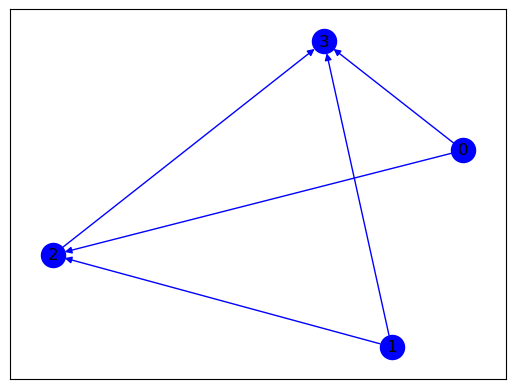

NET is ready


In [436]:
## build network graphics class and plot structure

NET = Networkx_Net(scale, squish)
NET.buildNetwork(BigClass)
NET.build_pos_lattice(BigClass, plot=True, node_labels=True)
BigClass.add_NET(NET)  # add to big class

In [437]:
Strctr.EIEJ_plots

[(0, 2), (1, 2), (0, 3), (1, 3), (2, 3)]

## Train

In [438]:
for i in range(Variabs.iterations):
    print('i', i)
    
    # if i<(200):
    if i<(iterations/2):
        pass
    else:
        # Variabs.R_update = 'deltaR_propto_Q'
        Variabs.lam = lam2
    
    # if task is classification and iteration # is beginning of epoch
    # draw output of network as output of mean of Irises
    if i % iterations == 0 and task_type == 'Iris_classification':
        State.assign_targets_Iris(BigClass)

    # staying stay_sample iteration under same sample
    if use_p_tag and noise_to_extra:
        k = 2*(i//stay_sample) + 1
        if not(i%4):
            k-=1
    elif use_p_tag and not(noise_to_extra):
        k = (i//stay_sample)*2 + i%2
    elif not(use_p_tag) and noise_to_extra:
        k = (i//stay_sample)
    else:
        k = (i//stay_sample)
    print('k', k)
    
    # draw input and desired outputs from dataset
    if not((i+1) % 4):  # add noise only at i=3 etc.
        State.draw_p_in_and_desired(Variabs, k, noise_to_extra=noise_to_extra)  # add noise to extra nodes every 2nd iteration
        State.solve_flow_given_problem(BigClass, "measure", noise_to_extra=noise_to_extra)  # measure and don't change resistances
    else:  # dont add noise to extra nodes
        State.draw_p_in_and_desired(Variabs, k)
        State.solve_flow_given_problem(BigClass, "measure")
        
    if include_Power:
        State.calc_Power_norm(BigClass)
    
    if not i % 2 and use_p_tag:  # even iterations, take another sampled pressure and measure again
        pass
    else:  # odd iterations, go to dual problem and update resistances
        State.t += 1
        print('time=', State.t)
        State.calc_loss(BigClass)
        print('loss', State.loss)
        if not((i+1) % 4) and access_interNodes:
            print('updating inters')
            State.update_inter_dual(BigClass)
            print('solving dual problem')
            State.solve_flow_given_problem(BigClass, "dual", access_inters=True)  # measure and don't change resistances
        else:
            State.update_input_dual(BigClass)
            # State.update_extraInput_dual(BigClass)
            State.update_output_dual(BigClass)
            # State.update_extraOutput_dual(BigClass)
            print('solving dual problem')
            State.solve_flow_given_problem(BigClass, "dual", access_inters=False)  # measure and don't change resistances
        # print('p', State.p)
        # print('u', State.u)
        print('updating Rs')
        State.update_Rs(BigClass)
        # print('Rs', State.R_in_t[-1])
        
    # measure accuracy
    if i % measure_accuracy_every == 0 and task_type == 'Iris_classification' \
       and i//measure_accuracy_every<len(State.accuracy_in_t) and i>0:
        State.calculate_accuracy_fullDataset(BigClass)
        State.accuracy_in_t[i//measure_accuracy_every] = State.accuracy 
        State.t_for_accuracy[i//measure_accuracy_every] = State.t 

i 0
k 0
time= 1
Power_norm 1.4393144382021894
lam -100
using power
loss before power [[-0.39085519]]
loss after power  [[-144.32229901]]
loss [[-144.32229901]]
solving dual problem
updating Rs
i 1
k 0
time= 2
Power_norm 0.012101555433536899
lam -100
using power
loss before power [[-0.04379644]]
loss after power  [[-1.25395199]]
loss [[-1.25395199]]
solving dual problem
updating Rs
i 2
k 1
time= 3
Power_norm 0.01751148899236879
lam -100
using power
loss before power [[-0.15957024]]
loss after power  [[-1.91071913]]
loss [[-1.91071913]]
solving dual problem
updating Rs
i 3
k 1
time= 4
Power_norm 0.017207568988812198
lam -100
using power
loss before power [[-0.1515616]]
loss after power  [[-1.8723185]]
loss [[-1.8723185]]
solving dual problem
updating Rs
i 4
k 2
time= 5
Power_norm 0.015714804887361856
lam -100
using power
loss before power [[-0.0286828]]
loss after power  [[-1.60016329]]
loss [[-1.60016329]]
solving dual problem
updating Rs
i 5
k 2
time= 6
Power_norm 0.015669905030679922


time= 151
Power_norm 0.01071746410238978
lam -100
using power
loss before power [[0.09025382]]
loss after power  [[-0.98149259]]
loss [[-0.98149259]]
solving dual problem
updating Rs
i 151
k 75
time= 152
Power_norm 0.010661740035538344
lam -100
using power
loss before power [[0.09195602]]
loss after power  [[-0.97421798]]
loss [[-0.97421798]]
solving dual problem
updating Rs
i 152
k 76
time= 153
Power_norm 0.007750931189551178
lam -100
using power
loss before power [[0.10932922]]
loss after power  [[-0.6657639]]
loss [[-0.6657639]]
solving dual problem
updating Rs
i 153
k 76
time= 154
Power_norm 0.0077415288828542456
lam -100
using power
loss before power [[0.1095588]]
loss after power  [[-0.66459409]]
loss [[-0.66459409]]
solving dual problem
updating Rs
i 154
k 77
time= 155
Power_norm 0.01063405379372598
lam -100
using power
loss before power [[0.09869764]]
loss after power  [[-0.96470774]]
loss [[-0.96470774]]
solving dual problem
updating Rs
i 155
k 77
time= 156
Power_norm 0.010575

updating Rs
i 310
k 155
time= 311
Power_norm 0.008167424278726909
lam -100
using power
loss before power [[0.08139196]]
loss after power  [[-0.73535047]]
loss [[-0.73535047]]
solving dual problem
updating Rs
i 311
k 155
time= 312
Power_norm 0.008156118766555346
lam -100
using power
loss before power [[0.08154605]]
loss after power  [[-0.73406582]]
loss [[-0.73406582]]
solving dual problem
updating Rs
i 312
k 156
time= 313
Power_norm 0.006513811640998997
lam -100
using power
loss before power [[0.26024042]]
loss after power  [[-0.39114075]]
loss [[-0.39114075]]
solving dual problem
updating Rs
i 313
k 156
time= 314
Power_norm 0.006505501764010038
lam -100
using power
loss before power [[0.26048]]
loss after power  [[-0.39007017]]
loss [[-0.39007017]]
solving dual problem
updating Rs
i 314
k 157
time= 315
Power_norm 0.007330134306653916
lam -100
using power
loss before power [[0.30191732]]
loss after power  [[-0.43109611]]
loss [[-0.43109611]]
solving dual problem
updating Rs
i 315
k 157

updating Rs
i 507
k 253
time= 508
Power_norm 0.006344246623296887
lam -100
using power
loss before power [[0.40881377]]
loss after power  [[-0.22561089]]
loss [[-0.22561089]]
solving dual problem
updating Rs
i 508
k 254
time= 509
Power_norm 0.006452560093841007
lam -100
using power
loss before power [[0.38715036]]
loss after power  [[-0.25810565]]
loss [[-0.25810565]]
solving dual problem
updating Rs
i 509
k 254
time= 510
Power_norm 0.006447615907168917
lam -100
using power
loss before power [[0.38744472]]
loss after power  [[-0.25731687]]
loss [[-0.25731687]]
solving dual problem
updating Rs
i 510
k 255
time= 511
Power_norm 0.0065161536424109805
lam -100
using power
loss before power [[0.23533593]]
loss after power  [[-0.41627943]]
loss [[-0.41627943]]
solving dual problem
updating Rs
i 511
k 255
time= 512
Power_norm 0.006510937756658108
lam -100
using power
loss before power [[0.23551868]]
loss after power  [[-0.41557509]]
loss [[-0.41557509]]
solving dual problem
updating Rs
i 512
k

updating Rs
i 714
k 357
time= 715
Power_norm 0.005343849687169723
lam -100
using power
loss before power [[0.36530646]]
loss after power  [[-0.16907851]]
loss [[-0.16907851]]
solving dual problem
updating Rs
i 715
k 357
time= 716
Power_norm 0.005341790615922249
lam -100
using power
loss before power [[0.36538777]]
loss after power  [[-0.1687913]]
loss [[-0.1687913]]
solving dual problem
updating Rs
i 716
k 358
time= 717
Power_norm 0.005629956005392089
lam -100
using power
loss before power [[0.4745019]]
loss after power  [[-0.0884937]]
loss [[-0.0884937]]
solving dual problem
updating Rs
i 717
k 358
time= 718
Power_norm 0.005628675255915309
lam -100
using power
loss before power [[0.47458608]]
loss after power  [[-0.08828145]]
loss [[-0.08828145]]
solving dual problem
updating Rs
i 718
k 359
time= 719
Power_norm 0.005270695052373046
lam -100
using power
loss before power [[0.25698839]]
loss after power  [[-0.27008111]]
loss [[-0.27008111]]
solving dual problem
updating Rs
i 719
k 359
t

time= 929
Power_norm 0.005695827834357315
lam -100
using power
loss before power [[0.22275358]]
loss after power  [[-0.3468292]]
loss [[-0.3468292]]
solving dual problem
updating Rs
i 929
k 464
time= 930
Power_norm 0.0056923738907081346
lam -100
using power
loss before power [[0.22283079]]
loss after power  [[-0.34640659]]
loss [[-0.34640659]]
solving dual problem
updating Rs
i 930
k 465
time= 931
Power_norm 0.004929936376571235
lam -100
using power
loss before power [[0.30525639]]
loss after power  [[-0.18773725]]
loss [[-0.18773725]]
solving dual problem
updating Rs
i 931
k 465
time= 932
Power_norm 0.004928045828542529
lam -100
using power
loss before power [[0.30530155]]
loss after power  [[-0.18750303]]
loss [[-0.18750303]]
solving dual problem
updating Rs
i 932
k 466
time= 933
Power_norm 0.005599584328486278
lam -100
using power
loss before power [[0.38764508]]
loss after power  [[-0.17231336]]
loss [[-0.17231336]]
solving dual problem
updating Rs
i 933
k 466
time= 934
Power_norm 

time= 1081
Power_norm 0.005594089374561075
lam -100
using power
loss before power [[0.20717718]]
loss after power  [[-0.35223176]]
loss [[-0.35223176]]
solving dual problem
updating Rs
i 1081
k 540
time= 1082
Power_norm 0.005589658749937928
lam -100
using power
loss before power [[0.20725779]]
loss after power  [[-0.35170808]]
loss [[-0.35170808]]
solving dual problem
updating Rs
i 1082
k 541
time= 1083
Power_norm 0.00486256726692843
lam -100
using power
loss before power [[0.38888109]]
loss after power  [[-0.09737564]]
loss [[-0.09737564]]
solving dual problem
updating Rs
i 1083
k 541
time= 1084
Power_norm 0.004861665511097944
lam -100
using power
loss before power [[0.38891552]]
loss after power  [[-0.09725103]]
loss [[-0.09725103]]
solving dual problem
updating Rs
i 1084
k 542
time= 1085
Power_norm 0.0053836376133397324
lam -100
using power
loss before power [[0.36984419]]
loss after power  [[-0.16851957]]
loss [[-0.16851957]]
solving dual problem
updating Rs
i 1085
k 542
time= 1086

time= 1263
Power_norm 0.00477852602526843
lam -100
using power
loss before power [[0.22746462]]
loss after power  [[-0.25038799]]
loss [[-0.25038799]]
solving dual problem
updating Rs
i 1263
k 631
time= 1264
Power_norm 0.004777368866013549
lam -100
using power
loss before power [[0.22749181]]
loss after power  [[-0.25024508]]
loss [[-0.25024508]]
solving dual problem
updating Rs
i 1264
k 632
time= 1265
Power_norm 0.004610537648152195
lam -100
using power
loss before power [[0.02740276]]
loss after power  [[-0.433651]]
loss [[-0.433651]]
solving dual problem
updating Rs
i 1265
k 632
time= 1266
Power_norm 0.004610205951291031
lam -100
using power
loss before power [[0.02740338]]
loss after power  [[-0.43361721]]
loss [[-0.43361721]]
solving dual problem
updating Rs
i 1266
k 633
time= 1267
Power_norm 0.004831739000239917
lam -100
using power
loss before power [[0.25510374]]
loss after power  [[-0.22807016]]
loss [[-0.22807016]]
solving dual problem
updating Rs
i 1267
k 633
time= 1268
Powe

time= 1484
Power_norm 0.005085487692422429
lam -100
using power
loss before power [[0.13229836]]
loss after power  [[-0.37625041]]
loss [[-0.37625041]]
solving dual problem
updating Rs
i 1484
k 742
time= 1485
Power_norm 0.004680530361941631
lam -100
using power
loss before power [[0.20439107]]
loss after power  [[-0.26366197]]
loss [[-0.26366197]]
solving dual problem
updating Rs
i 1485
k 742
time= 1486
Power_norm 0.004679522974512874
lam -100
using power
loss before power [[0.20441195]]
loss after power  [[-0.26354035]]
loss [[-0.26354035]]
solving dual problem
updating Rs
i 1486
k 743
time= 1487
Power_norm 0.004567040773581738
lam -100
using power
loss before power [[0.33533685]]
loss after power  [[-0.12136723]]
loss [[-0.12136723]]
solving dual problem
updating Rs
i 1487
k 743
time= 1488
Power_norm 0.0045662626843321575
lam -100
using power
loss before power [[0.33536066]]
loss after power  [[-0.12126561]]
loss [[-0.12126561]]
solving dual problem
updating Rs
i 1488
k 744
time= 148

time= 1685
Power_norm 0.004351234947442258
lam -100
using power
loss before power [[0.33334757]]
loss after power  [[-0.10177593]]
loss [[-0.10177593]]
solving dual problem
updating Rs
i 1685
k 842
time= 1686
Power_norm 0.004350409592837037
lam -100
using power
loss before power [[0.33336429]]
loss after power  [[-0.10167667]]
loss [[-0.10167667]]
solving dual problem
updating Rs
i 1686
k 843
time= 1687
Power_norm 0.004753773440597636
lam -100
using power
loss before power [[0.39492104]]
loss after power  [[-0.08045631]]
loss [[-0.08045631]]
solving dual problem
updating Rs
i 1687
k 843
time= 1688
Power_norm 0.004752990903885604
lam -100
using power
loss before power [[0.39494735]]
loss after power  [[-0.08035174]]
loss [[-0.08035174]]
solving dual problem
updating Rs
i 1688
k 844
time= 1689
Power_norm 0.004518653624822489
lam -100
using power
loss before power [[0.41488047]]
loss after power  [[-0.0369849]]
loss [[-0.0369849]]
solving dual problem
updating Rs
i 1689
k 844
time= 1690
P

time= 1904
Power_norm 0.004768528317313315
lam -100
using power
loss before power [[0.20058643]]
loss after power  [[-0.2762664]]
loss [[-0.2762664]]
solving dual problem
updating Rs
i 1904
k 952
time= 1905
Power_norm 0.004711438000826434
lam -100
using power
loss before power [[0.2557286]]
loss after power  [[-0.2154152]]
loss [[-0.2154152]]
solving dual problem
updating Rs
i 1905
k 952
time= 1906
Power_norm 0.00470968988497614
lam -100
using power
loss before power [[0.25576104]]
loss after power  [[-0.21520794]]
loss [[-0.21520794]]
solving dual problem
updating Rs
i 1906
k 953
time= 1907
Power_norm 0.004669336592074332
lam -100
using power
loss before power [[0.36660388]]
loss after power  [[-0.10032978]]
loss [[-0.10032978]]
solving dual problem
updating Rs
i 1907
k 953
time= 1908
Power_norm 0.004668336783654035
lam -100
using power
loss before power [[0.3666318]]
loss after power  [[-0.10020188]]
loss [[-0.10020188]]
solving dual problem
updating Rs
i 1908
k 954
time= 1909
Power_

updating Rs
i 2132
k 1066
time= 2133
Power_norm 0.004374532296295287
lam -100
using power
loss before power [[0.32732224]]
loss after power  [[-0.11013099]]
loss [[-0.11013099]]
solving dual problem
updating Rs
i 2133
k 1066
time= 2134
Power_norm 0.004373951933176199
lam -100
using power
loss before power [[0.32733921]]
loss after power  [[-0.11005598]]
loss [[-0.11005598]]
solving dual problem
updating Rs
i 2134
k 1067
time= 2135
Power_norm 0.0043122405107284415
lam -100
using power
loss before power [[0.49608545]]
loss after power  [[0.0648614]]
loss [[0.0648614]]
solving dual problem
updating Rs
i 2135
k 1067
time= 2136
Power_norm 0.0043127352575285365
lam -100
using power
loss before power [[0.49606383]]
loss after power  [[0.06479031]]
loss [[0.06479031]]
solving dual problem
updating Rs
i 2136
k 1068
time= 2137
Power_norm 0.004171732782444923
lam -100
using power
loss before power [[0.27941727]]
loss after power  [[-0.137756]]
loss [[-0.137756]]
solving dual problem
updating Rs
i

updating Rs
i 2357
k 1178
time= 2358
Power_norm 0.004505479098154955
lam -100
using power
loss before power [[0.25222675]]
loss after power  [[-0.19832116]]
loss [[-0.19832116]]
solving dual problem
updating Rs
i 2358
k 1179
time= 2359
Power_norm 0.004464262406299318
lam -100
using power
loss before power [[0.18595286]]
loss after power  [[-0.26047338]]
loss [[-0.26047338]]
solving dual problem
updating Rs
i 2359
k 1179
time= 2360
Power_norm 0.004462907341168721
lam -100
using power
loss before power [[0.18596992]]
loss after power  [[-0.26032081]]
loss [[-0.26032081]]
solving dual problem
updating Rs
i 2360
k 1180
time= 2361
Power_norm 0.004108790536055293
lam -100
using power
loss before power [[0.15359677]]
loss after power  [[-0.25728228]]
loss [[-0.25728228]]
solving dual problem
updating Rs
i 2361
k 1180
time= 2362
Power_norm 0.004107859599590652
lam -100
using power
loss before power [[0.15360389]]
loss after power  [[-0.25718207]]
loss [[-0.25718207]]
solving dual problem
updat

time= 2572
Power_norm 0.004100295658994417
lam -100
using power
loss before power [[0.42788951]]
loss after power  [[0.01785994]]
loss [[0.01785994]]
solving dual problem
updating Rs
i 2572
k 1286
time= 2573
Power_norm 0.004145273186654191
lam -100
using power
loss before power [[0.2526519]]
loss after power  [[-0.16187542]]
loss [[-0.16187542]]
solving dual problem
updating Rs
i 2573
k 1286
time= 2574
Power_norm 0.004144681585567401
lam -100
using power
loss before power [[0.25266376]]
loss after power  [[-0.1618044]]
loss [[-0.1618044]]
solving dual problem
updating Rs
i 2574
k 1287
time= 2575
Power_norm 0.004084016720756109
lam -100
using power
loss before power [[0.28709155]]
loss after power  [[-0.12131013]]
loss [[-0.12131013]]
solving dual problem
updating Rs
i 2575
k 1287
time= 2576
Power_norm 0.0040834143696737765
lam -100
using power
loss before power [[0.28710243]]
loss after power  [[-0.12123901]]
loss [[-0.12123901]]
solving dual problem
updating Rs
i 2576
k 1288
time= 257

time= 2787
Power_norm 0.004323827445525163
lam -100
using power
loss before power [[0.31748111]]
loss after power  [[-0.11490163]]
loss [[-0.11490163]]
solving dual problem
updating Rs
i 2787
k 1393
time= 2788
Power_norm 0.004322805605709495
lam -100
using power
loss before power [[0.31750174]]
loss after power  [[-0.11477882]]
loss [[-0.11477882]]
solving dual problem
updating Rs
i 2788
k 1394
time= 2789
Power_norm 0.0041379964640687805
lam -100
using power
loss before power [[0.60216355]]
loss after power  [[0.18836391]]
loss [[0.18836391]]
solving dual problem
updating Rs
i 2789
k 1394
time= 2790
Power_norm 0.004139574496926195
lam -100
using power
loss before power [[0.60208516]]
loss after power  [[0.18812771]]
loss [[0.18812771]]
solving dual problem
updating Rs
i 2790
k 1395
time= 2791
Power_norm 0.004098761687238575
lam -100
using power
loss before power [[0.53555231]]
loss after power  [[0.12567614]]
loss [[0.12567614]]
solving dual problem
updating Rs
i 2791
k 1395
time= 2792

updating Rs
i 3008
k 1504
time= 3009
Power_norm 0.004280184390368441
lam -100
using power
loss before power [[0.19256434]]
loss after power  [[-0.2354541]]
loss [[-0.2354541]]
solving dual problem
updating Rs
i 3009
k 1504
time= 3010
Power_norm 0.004278711599555247
lam -100
using power
loss before power [[0.19258194]]
loss after power  [[-0.23528922]]
loss [[-0.23528922]]
solving dual problem
updating Rs
i 3010
k 1505
time= 3011
Power_norm 0.004192687101816145
lam -100
using power
loss before power [[0.24530194]]
loss after power  [[-0.17396677]]
loss [[-0.17396677]]
solving dual problem
updating Rs
i 3011
k 1505
time= 3012
Power_norm 0.004191915569849079
lam -100
using power
loss before power [[0.24531569]]
loss after power  [[-0.17387587]]
loss [[-0.17387587]]
solving dual problem
updating Rs
i 3012
k 1506
time= 3013
Power_norm 0.004084726361735425
lam -100
using power
loss before power [[0.20640692]]
loss after power  [[-0.20206571]]
loss [[-0.20206571]]
solving dual problem
updatin

updating Rs
i 3215
k 1607
time= 3216
Power_norm 0.004135910500590156
lam -100
using power
loss before power [[0.10207374]]
loss after power  [[-0.31151731]]
loss [[-0.31151731]]
solving dual problem
updating Rs
i 3216
k 1608
time= 3217
Power_norm 0.004216960945180005
lam -100
using power
loss before power [[0.04360303]]
loss after power  [[-0.37809307]]
loss [[-0.37809307]]
solving dual problem
updating Rs
i 3217
k 1608
time= 3218
Power_norm 0.004216395723389958
lam -100
using power
loss before power [[0.04360455]]
loss after power  [[-0.37803502]]
loss [[-0.37803502]]
solving dual problem
updating Rs
i 3218
k 1609
time= 3219
Power_norm 0.004050472116106304
lam -100
using power
loss before power [[0.45134701]]
loss after power  [[0.0462998]]
loss [[0.0462998]]
solving dual problem
updating Rs
i 3219
k 1609
time= 3220
Power_norm 0.0040507490082104846
lam -100
using power
loss before power [[0.45133706]]
loss after power  [[0.04626216]]
loss [[0.04626216]]
solving dual problem
updating R

time= 3436
Power_norm 0.004078854665560419
lam -100
using power
loss before power [[0.3253724]]
loss after power  [[-0.08251306]]
loss [[-0.08251306]]
solving dual problem
updating Rs
i 3436
k 1718
time= 3437
Power_norm 0.003944559668711216
lam -100
using power
loss before power [[0.27593579]]
loss after power  [[-0.11852018]]
loss [[-0.11852018]]
solving dual problem
updating Rs
i 3437
k 1718
time= 3438
Power_norm 0.003944050998097071
lam -100
using power
loss before power [[0.27594412]]
loss after power  [[-0.11846098]]
loss [[-0.11846098]]
solving dual problem
updating Rs
i 3438
k 1719
time= 3439
Power_norm 0.004013553182934167
lam -100
using power
loss before power [[0.57860989]]
loss after power  [[0.17725457]]
loss [[0.17725457]]
solving dual problem
updating Rs
i 3439
k 1719
time= 3440
Power_norm 0.0040148857897641345
lam -100
using power
loss before power [[0.5785494]]
loss after power  [[0.17706082]]
loss [[0.17706082]]
solving dual problem
updating Rs
i 3440
k 1720
time= 3441

time= 3650
Power_norm 0.003935635755185699
lam -100
using power
loss before power [[0.51907889]]
loss after power  [[0.12551531]]
loss [[0.12551531]]
solving dual problem
updating Rs
i 3650
k 1825
time= 3651
Power_norm 0.004045786035426462
lam -100
using power
loss before power [[0.3456614]]
loss after power  [[-0.0589172]]
loss [[-0.0589172]]
solving dual problem
updating Rs
i 3651
k 1825
time= 3652
Power_norm 0.004045446109980413
lam -100
using power
loss before power [[0.34566955]]
loss after power  [[-0.05887507]]
loss [[-0.05887507]]
solving dual problem
updating Rs
i 3652
k 1826
time= 3653
Power_norm 0.004093842248515411
lam -100
using power
loss before power [[0.27837799]]
loss after power  [[-0.13100623]]
loss [[-0.13100623]]
solving dual problem
updating Rs
i 3653
k 1826
time= 3654
Power_norm 0.004092946160570809
lam -100
using power
loss before power [[0.27839295]]
loss after power  [[-0.13090167]]
loss [[-0.13090167]]
solving dual problem
updating Rs
i 3654
k 1827
time= 3655

time= 3884
Power_norm 0.004035204637586617
lam -100
using power
loss before power [[0.33181837]]
loss after power  [[-0.0717021]]
loss [[-0.0717021]]
solving dual problem
updating Rs
i 3884
k 1942
time= 3885
Power_norm 0.003935023533638453
lam -100
using power
loss before power [[0.57276864]]
loss after power  [[0.17926629]]
loss [[0.17926629]]
solving dual problem
updating Rs
i 3885
k 1942
time= 3886
Power_norm 0.003936293040089849
lam -100
using power
loss before power [[0.57271347]]
loss after power  [[0.17908417]]
loss [[0.17908417]]
solving dual problem
updating Rs
i 3886
k 1943
time= 3887
Power_norm 0.003974078644610034
lam -100
using power
loss before power [[0.47182514]]
loss after power  [[0.07441728]]
loss [[0.07441728]]
solving dual problem
updating Rs
i 3887
k 1943
time= 3888
Power_norm 0.003974570249748108
lam -100
using power
loss before power [[0.4718081]]
loss after power  [[0.07435108]]
loss [[0.07435108]]
solving dual problem
updating Rs
i 3888
k 1944
time= 3889
Power

time= 4118
Power_norm 0.0039580919250790615
lam -100
using power
loss before power [[0.39004367]]
loss after power  [[-0.00576552]]
loss [[-0.00576552]]
solving dual problem
updating Rs
i 4118
k 2059
time= 4119
Power_norm 0.0038595120351727
lam -100
using power
loss before power [[0.29840932]]
loss after power  [[-0.08754188]]
loss [[-0.08754188]]
solving dual problem
updating Rs
i 4119
k 2059
time= 4120
Power_norm 0.0038590549896348465
lam -100
using power
loss before power [[0.29841587]]
loss after power  [[-0.08748963]]
loss [[-0.08748963]]
solving dual problem
updating Rs
i 4120
k 2060
time= 4121
Power_norm 0.003871462714644443
lam -100
using power
loss before power [[0.26896095]]
loss after power  [[-0.11818532]]
loss [[-0.11818532]]
solving dual problem
updating Rs
i 4121
k 2060
time= 4122
Power_norm 0.0038710454997506073
lam -100
using power
loss before power [[0.2689682]]
loss after power  [[-0.11813635]]
loss [[-0.11813635]]
solving dual problem
updating Rs
i 4122
k 2061
time=

time= 4340
Power_norm 0.003919006566222097
lam -100
using power
loss before power [[0.18018481]]
loss after power  [[-0.21171585]]
loss [[-0.21171585]]
solving dual problem
updating Rs
i 4340
k 2170
time= 4341
Power_norm 0.0039652176967422135
lam -100
using power
loss before power [[0.13455162]]
loss after power  [[-0.26197015]]
loss [[-0.26197015]]
solving dual problem
updating Rs
i 4341
k 2170
time= 4342
Power_norm 0.00396430128840654
lam -100
using power
loss before power [[0.13455864]]
loss after power  [[-0.26187149]]
loss [[-0.26187149]]
solving dual problem
updating Rs
i 4342
k 2171
time= 4343
Power_norm 0.00388229580688571
lam -100
using power
loss before power [[0.51841471]]
loss after power  [[0.13018513]]
loss [[0.13018513]]
solving dual problem
updating Rs
i 4343
k 2171
time= 4344
Power_norm 0.003883106947775544
lam -100
using power
loss before power [[0.51838346]]
loss after power  [[0.13007277]]
loss [[0.13007277]]
solving dual problem
updating Rs
i 4344
k 2172
time= 4345

time= 4566
Power_norm 0.003831868412270733
lam -100
using power
loss before power [[0.38917145]]
loss after power  [[0.00598461]]
loss [[0.00598461]]
solving dual problem
updating Rs
i 4566
k 2283
time= 4567
Power_norm 0.003869946423098868
lam -100
using power
loss before power [[0.1484618]]
loss after power  [[-0.23853285]]
loss [[-0.23853285]]
solving dual problem
updating Rs
i 4567
k 2283
time= 4568
Power_norm 0.0038695131411785413
lam -100
using power
loss before power [[0.14846653]]
loss after power  [[-0.23848478]]
loss [[-0.23848478]]
solving dual problem
updating Rs
i 4568
k 2284
time= 4569
Power_norm 0.0038324120517748473
lam -100
using power
loss before power [[0.35059595]]
loss after power  [[-0.03264525]]
loss [[-0.03264525]]
solving dual problem
updating Rs
i 4569
k 2284
time= 4570
Power_norm 0.003832207773711873
lam -100
using power
loss before power [[0.35059922]]
loss after power  [[-0.03262155]]
loss [[-0.03262155]]
solving dual problem
updating Rs
i 4570
k 2285
time= 

updating Rs
i 4786
k 2393
time= 4787
Power_norm 0.003848733338750898
lam -100
using power
loss before power [[0.56322207]]
loss after power  [[0.17834873]]
loss [[0.17834873]]
solving dual problem
updating Rs
i 4787
k 2393
time= 4788
Power_norm 0.003849914782417571
lam -100
using power
loss before power [[0.56317339]]
loss after power  [[0.17818191]]
loss [[0.17818191]]
solving dual problem
updating Rs
i 4788
k 2394
time= 4789
Power_norm 0.00386986408403206
lam -100
using power
loss before power [[0.2513511]]
loss after power  [[-0.13563531]]
loss [[-0.13563531]]
solving dual problem
updating Rs
i 4789
k 2394
time= 4790
Power_norm 0.003869410224942076
lam -100
using power
loss before power [[0.25135917]]
loss after power  [[-0.13558185]]
loss [[-0.13558185]]
solving dual problem
updating Rs
i 4790
k 2395
time= 4791
Power_norm 0.0038362403208935863
lam -100
using power
loss before power [[0.37691686]]
loss after power  [[-0.00670717]]
loss [[-0.00670717]]
solving dual problem
updating R

updating Rs
i 5013
k 2506
time= 5014
Power_norm 0.003830536086859547
lam -100
using power
loss before power [[0.37460098]]
loss after power  [[-0.00845263]]
loss [[-0.00845263]]
solving dual problem
updating Rs
i 5014
k 2507
time= 5015
Power_norm 0.0038334787175385125
lam -100
using power
loss before power [[0.12964445]]
loss after power  [[-0.25370342]]
loss [[-0.25370342]]
solving dual problem
updating Rs
i 5015
k 2507
time= 5016
Power_norm 0.0038330960138962668
lam -100
using power
loss before power [[0.12964804]]
loss after power  [[-0.25366156]]
loss [[-0.25366156]]
solving dual problem
updating Rs
i 5016
k 2508
time= 5017
Power_norm 0.0038234650607993897
lam -100
using power
loss before power [[0.12888775]]
loss after power  [[-0.25345876]]
loss [[-0.25345876]]
solving dual problem
updating Rs
i 5017
k 2508
time= 5018
Power_norm 0.0038228687225653406
lam -100
using power
loss before power [[0.12889114]]
loss after power  [[-0.25339573]]
loss [[-0.25339573]]
solving dual problem
u

time= 5237
Power_norm 0.0038180366467369608
lam -100
using power
loss before power [[0.42621447]]
loss after power  [[0.0444108]]
loss [[0.0444108]]
solving dual problem
updating Rs
i 5237
k 2618
time= 5238
Power_norm 0.0038182567236245604
lam -100
using power
loss before power [[0.42620767]]
loss after power  [[0.044382]]
loss [[0.044382]]
solving dual problem
updating Rs
i 5238
k 2619
time= 5239
Power_norm 0.003822843238504458
lam -100
using power
loss before power [[0.14508816]]
loss after power  [[-0.23719617]]
loss [[-0.23719617]]
solving dual problem
updating Rs
i 5239
k 2619
time= 5240
Power_norm 0.003822202135695742
lam -100
using power
loss before power [[0.14509216]]
loss after power  [[-0.23712806]]
loss [[-0.23712806]]
solving dual problem
updating Rs
i 5240
k 2620
time= 5241
Power_norm 0.0038379457907844086
lam -100
using power
loss before power [[0.41451405]]
loss after power  [[0.03071947]]
loss [[0.03071947]]
solving dual problem
updating Rs
i 5241
k 2620
time= 5242
Pow

time= 5458
Power_norm 0.0038011261554400746
lam -100
using power
loss before power [[0.24097627]]
loss after power  [[-0.13913635]]
loss [[-0.13913635]]
solving dual problem
updating Rs
i 5458
k 2729
time= 5459
Power_norm 0.003801570842532242
lam -100
using power
loss before power [[0.61008314]]
loss after power  [[0.22992606]]
loss [[0.22992606]]
solving dual problem
updating Rs
i 5459
k 2729
time= 5460
Power_norm 0.0038031820154286857
lam -100
using power
loss before power [[0.61001244]]
loss after power  [[0.22969424]]
loss [[0.22969424]]
solving dual problem
updating Rs
i 5460
k 2730
time= 5461
Power_norm 0.0038259360043070953
lam -100
using power
loss before power [[0.30167017]]
loss after power  [[-0.08092343]]
loss [[-0.08092343]]
solving dual problem
updating Rs
i 5461
k 2730
time= 5462
Power_norm 0.0038254837181329994
lam -100
using power
loss before power [[0.30167818]]
loss after power  [[-0.08087019]]
loss [[-0.08087019]]
solving dual problem
updating Rs
i 5462
k 2731
time=

updating Rs
i 5668
k 2834
time= 5669
Power_norm 0.0038157906414311017
lam -100
using power
loss before power [[0.28903823]]
loss after power  [[-0.09254084]]
loss [[-0.09254084]]
solving dual problem
updating Rs
i 5669
k 2834
time= 5670
Power_norm 0.0038152824451220375
lam -100
using power
loss before power [[0.28904439]]
loss after power  [[-0.09248386]]
loss [[-0.09248386]]
solving dual problem
updating Rs
i 5670
k 2835
time= 5671
Power_norm 0.0038137159671361933
lam -100
using power
loss before power [[0.33168704]]
loss after power  [[-0.04968455]]
loss [[-0.04968455]]
solving dual problem
updating Rs
i 5671
k 2835
time= 5672
Power_norm 0.0038134255997887803
lam -100
using power
loss before power [[0.33169278]]
loss after power  [[-0.04964978]]
loss [[-0.04964978]]
solving dual problem
updating Rs
i 5672
k 2836
time= 5673
Power_norm 0.003806598232707581
lam -100
using power
loss before power [[0.28589228]]
loss after power  [[-0.09476754]]
loss [[-0.09476754]]
solving dual problem
u

time= 5875
Power_norm 0.0037879835737264322
lam -100
using power
loss before power [[0.20567192]]
loss after power  [[-0.17312644]]
loss [[-0.17312644]]
solving dual problem
updating Rs
i 5875
k 2937
time= 5876
Power_norm 0.0037875186708831695
lam -100
using power
loss before power [[0.20567843]]
loss after power  [[-0.17307344]]
loss [[-0.17307344]]
solving dual problem
updating Rs
i 5876
k 2938
time= 5877
Power_norm 0.0037850777932829905
lam -100
using power
loss before power [[0.47692203]]
loss after power  [[0.09841425]]
loss [[0.09841425]]
solving dual problem
updating Rs
i 5877
k 2938
time= 5878
Power_norm 0.003785639668182897
lam -100
using power
loss before power [[0.47690307]]
loss after power  [[0.0983391]]
loss [[0.0983391]]
solving dual problem
updating Rs
i 5878
k 2939
time= 5879
Power_norm 0.0037853782701266093
lam -100
using power
loss before power [[0.29855841]]
loss after power  [[-0.07997942]]
loss [[-0.07997942]]
solving dual problem
updating Rs
i 5879
k 2939
time= 5

time= 6105
Power_norm 0.003778732968433909
lam -100
using power
loss before power [[0.09935803]]
loss after power  [[-0.27851527]]
loss [[-0.27851527]]
solving dual problem
updating Rs
i 6105
k 3052
time= 6106
Power_norm 0.003778410553377128
lam -100
using power
loss before power [[0.09936014]]
loss after power  [[-0.27848092]]
loss [[-0.27848092]]
solving dual problem
updating Rs
i 6106
k 3053
time= 6107
Power_norm 0.003782868051628452
lam -100
using power
loss before power [[0.16181171]]
loss after power  [[-0.2164751]]
loss [[-0.2164751]]
solving dual problem
updating Rs
i 6107
k 3053
time= 6108
Power_norm 0.0037821113452898097
lam -100
using power
loss before power [[0.16181846]]
loss after power  [[-0.21639268]]
loss [[-0.21639268]]
solving dual problem
updating Rs
i 6108
k 3054
time= 6109
Power_norm 0.0037988525529335255
lam -100
using power
loss before power [[0.39879089]]
loss after power  [[0.01890563]]
loss [[0.01890563]]
solving dual problem
updating Rs
i 6109
k 3054
time= 6

time= 6331
Power_norm 0.0038021447163199946
lam -100
using power
loss before power [[0.27346051]]
loss after power  [[-0.10675396]]
loss [[-0.10675396]]
solving dual problem
updating Rs
i 6331
k 3165
time= 6332
Power_norm 0.0038015848538125586
lam -100
using power
loss before power [[0.27346675]]
loss after power  [[-0.10669173]]
loss [[-0.10669173]]
solving dual problem
updating Rs
i 6332
k 3166
time= 6333
Power_norm 0.0037587185425489167
lam -100
using power
loss before power [[0.33081914]]
loss after power  [[-0.04505271]]
loss [[-0.04505271]]
solving dual problem
updating Rs
i 6333
k 3166
time= 6334
Power_norm 0.00375855116498384
lam -100
using power
loss before power [[0.33082306]]
loss after power  [[-0.04503206]]
loss [[-0.04503206]]
solving dual problem
updating Rs
i 6334
k 3167
time= 6335
Power_norm 0.0037841342175745822
lam -100
using power
loss before power [[0.33860502]]
loss after power  [[-0.0398084]]
loss [[-0.0398084]]
solving dual problem
updating Rs
i 6335
k 3167
time

updating Rs
i 6553
k 3276
time= 6554
Power_norm 0.003764153424522671
lam -100
using power
loss before power [[0.15983318]]
loss after power  [[-0.21658217]]
loss [[-0.21658217]]
solving dual problem
updating Rs
i 6554
k 3277
time= 6555
Power_norm 0.003758571800492255
lam -100
using power
loss before power [[0.46549273]]
loss after power  [[0.08963555]]
loss [[0.08963555]]
solving dual problem
updating Rs
i 6555
k 3277
time= 6556
Power_norm 0.003759040955086489
lam -100
using power
loss before power [[0.46547727]]
loss after power  [[0.08957317]]
loss [[0.08957317]]
solving dual problem
updating Rs
i 6556
k 3278
time= 6557
Power_norm 0.0037581448558309666
lam -100
using power
loss before power [[0.1174497]]
loss after power  [[-0.25836479]]
loss [[-0.25836479]]
solving dual problem
updating Rs
i 6557
k 3278
time= 6558
Power_norm 0.003757479484023137
lam -100
using power
loss before power [[0.11745397]]
loss after power  [[-0.25829398]]
loss [[-0.25829398]]
solving dual problem
updating 

time= 6780
Power_norm 0.003740430401923997
lam -100
using power
loss before power [[0.28517807]]
loss after power  [[-0.08886497]]
loss [[-0.08886497]]
solving dual problem
updating Rs
i 6780
k 3390
time= 6781
Power_norm 0.0037584560707146007
lam -100
using power
loss before power [[0.27220026]]
loss after power  [[-0.10364535]]
loss [[-0.10364535]]
solving dual problem
updating Rs
i 6781
k 3390
time= 6782
Power_norm 0.0037581335881928654
lam -100
using power
loss before power [[0.27220602]]
loss after power  [[-0.10360734]]
loss [[-0.10360734]]
solving dual problem
updating Rs
i 6782
k 3391
time= 6783
Power_norm 0.0037357316421980005
lam -100
using power
loss before power [[0.25091438]]
loss after power  [[-0.12265878]]
loss [[-0.12265878]]
solving dual problem
updating Rs
i 6783
k 3391
time= 6784
Power_norm 0.0037353450282759573
lam -100
using power
loss before power [[0.25092093]]
loss after power  [[-0.12261357]]
loss [[-0.12261357]]
solving dual problem
updating Rs
i 6784
k 3392
t

time= 7007
Power_norm 0.0037228576703320637
lam -100
using power
loss before power [[0.14319886]]
loss after power  [[-0.22908691]]
loss [[-0.22908691]]
solving dual problem
updating Rs
i 7007
k 3503
time= 7008
Power_norm 0.003721999260143813
lam -100
using power
loss before power [[0.14320557]]
loss after power  [[-0.22899435]]
loss [[-0.22899435]]
solving dual problem
updating Rs
i 7008
k 3504
time= 7009
Power_norm 0.003731952105534069
lam -100
using power
loss before power [[0.14125497]]
loss after power  [[-0.23194024]]
loss [[-0.23194024]]
solving dual problem
updating Rs
i 7009
k 3504
time= 7010
Power_norm 0.0037315844667842016
lam -100
using power
loss before power [[0.14125861]]
loss after power  [[-0.23189983]]
loss [[-0.23189983]]
solving dual problem
updating Rs
i 7010
k 3505
time= 7011
Power_norm 0.0037853828974806114
lam -100
using power
loss before power [[0.36344426]]
loss after power  [[-0.01509403]]
loss [[-0.01509403]]
solving dual problem
updating Rs
i 7011
k 3505
ti

time= 7233
Power_norm 0.003808509625506807
lam -100
using power
loss before power [[0.21229519]]
loss after power  [[-0.16855577]]
loss [[-0.16855577]]
solving dual problem
updating Rs
i 7233
k 3616
time= 7234
Power_norm 0.0038078394237281046
lam -100
using power
loss before power [[0.212301]]
loss after power  [[-0.16848295]]
loss [[-0.16848295]]
solving dual problem
updating Rs
i 7234
k 3617
time= 7235
Power_norm 0.003751931069923232
lam -100
using power
loss before power [[0.26491359]]
loss after power  [[-0.11027951]]
loss [[-0.11027951]]
solving dual problem
updating Rs
i 7235
k 3617
time= 7236
Power_norm 0.0037515958434399107
lam -100
using power
loss before power [[0.26491932]]
loss after power  [[-0.11024027]]
loss [[-0.11024027]]
solving dual problem
updating Rs
i 7236
k 3618
time= 7237
Power_norm 0.003751975185637029
lam -100
using power
loss before power [[0.4839873]]
loss after power  [[0.10878978]]
loss [[0.10878978]]
solving dual problem
updating Rs
i 7237
k 3618
time= 72

time= 7459
Power_norm 0.003723265734913745
lam -100
using power
loss before power [[0.15515248]]
loss after power  [[-0.2171741]]
loss [[-0.2171741]]
solving dual problem
updating Rs
i 7459
k 3729
time= 7460
Power_norm 0.003722897388797694
lam -100
using power
loss before power [[0.15515634]]
loss after power  [[-0.21713339]]
loss [[-0.21713339]]
solving dual problem
updating Rs
i 7460
k 3730
time= 7461
Power_norm 0.0037013853102009263
lam -100
using power
loss before power [[0.26406154]]
loss after power  [[-0.106077]]
loss [[-0.106077]]
solving dual problem
updating Rs
i 7461
k 3730
time= 7462
Power_norm 0.0037010668069290915
lam -100
using power
loss before power [[0.26406734]]
loss after power  [[-0.10603934]]
loss [[-0.10603934]]
solving dual problem
updating Rs
i 7462
k 3731
time= 7463
Power_norm 0.003682307063115049
lam -100
using power
loss before power [[0.38122896]]
loss after power  [[0.01299825]]
loss [[0.01299825]]
solving dual problem
updating Rs
i 7463
k 3731
time= 7464


time= 7682
Power_norm 0.0036864666250596713
lam -100
using power
loss before power [[0.44710357]]
loss after power  [[0.07845691]]
loss [[0.07845691]]
solving dual problem
updating Rs
i 7682
k 3841
time= 7683
Power_norm 0.003700755899916248
lam -100
using power
loss before power [[0.3428704]]
loss after power  [[-0.02720519]]
loss [[-0.02720519]]
solving dual problem
updating Rs
i 7683
k 3841
time= 7684
Power_norm 0.003700650678490362
lam -100
using power
loss before power [[0.3428729]]
loss after power  [[-0.02719217]]
loss [[-0.02719217]]
solving dual problem
updating Rs
i 7684
k 3842
time= 7685
Power_norm 0.0037933427050613044
lam -100
using power
loss before power [[0.30783524]]
loss after power  [[-0.07149903]]
loss [[-0.07149903]]
solving dual problem
updating Rs
i 7685
k 3842
time= 7686
Power_norm 0.003792946798470653
lam -100
using power
loss before power [[0.30784027]]
loss after power  [[-0.07145441]]
loss [[-0.07145441]]
solving dual problem
updating Rs
i 7686
k 3843
time= 7

time= 7893
Power_norm 0.0036662823420067726
lam -100
using power
loss before power [[0.37856134]]
loss after power  [[0.0119331]]
loss [[0.0119331]]
solving dual problem
updating Rs
i 7893
k 3946
time= 7894
Power_norm 0.0036663399890538638
lam -100
using power
loss before power [[0.37855993]]
loss after power  [[0.01192593]]
loss [[0.01192593]]
solving dual problem
updating Rs
i 7894
k 3947
time= 7895
Power_norm 0.003729710479226828
lam -100
using power
loss before power [[0.44481829]]
loss after power  [[0.07184724]]
loss [[0.07184724]]
solving dual problem
updating Rs
i 7895
k 3947
time= 7896
Power_norm 0.003730095108231848
lam -100
using power
loss before power [[0.4448083]]
loss after power  [[0.07179879]]
loss [[0.07179879]]
solving dual problem
updating Rs
i 7896
k 3948
time= 7897
Power_norm 0.003676060430122117
lam -100
using power
loss before power [[0.37082129]]
loss after power  [[0.00321525]]
loss [[0.00321525]]
solving dual problem
updating Rs
i 7897
k 3948
time= 7898
Power

time= 8119
Power_norm 0.0037614638781568958
lam -100
using power
loss before power [[0.24146963]]
loss after power  [[-0.13467676]]
loss [[-0.13467676]]
solving dual problem
updating Rs
i 8119
k 4059
time= 8120
Power_norm 0.003760983353648994
lam -100
using power
loss before power [[0.24147513]]
loss after power  [[-0.1346232]]
loss [[-0.1346232]]
solving dual problem
updating Rs
i 8120
k 4060
time= 8121
Power_norm 0.0037442976120856445
lam -100
using power
loss before power [[0.3098572]]
loss after power  [[-0.06457256]]
loss [[-0.06457256]]
solving dual problem
updating Rs
i 8121
k 4060
time= 8122
Power_norm 0.0037440354764554607
lam -100
using power
loss before power [[0.30986153]]
loss after power  [[-0.06454202]]
loss [[-0.06454202]]
solving dual problem
updating Rs
i 8122
k 4061
time= 8123
Power_norm 0.0037753560926441607
lam -100
using power
loss before power [[0.27308931]]
loss after power  [[-0.1044463]]
loss [[-0.1044463]]
solving dual problem
updating Rs
i 8123
k 4061
time= 

updating Rs
i 8345
k 4172
time= 8346
Power_norm 0.0036602320315043436
lam -100
using power
loss before power [[0.53880917]]
loss after power  [[0.17278596]]
loss [[0.17278596]]
solving dual problem
updating Rs
i 8346
k 4173
time= 8347
Power_norm 0.0036282370666704785
lam -100
using power
loss before power [[0.23093268]]
loss after power  [[-0.13189103]]
loss [[-0.13189103]]
solving dual problem
updating Rs
i 8347
k 4173
time= 8348
Power_norm 0.003627524996198925
lam -100
using power
loss before power [[0.23094134]]
loss after power  [[-0.13181116]]
loss [[-0.13181116]]
solving dual problem
updating Rs
i 8348
k 4174
time= 8349
Power_norm 0.003702754732641577
lam -100
using power
loss before power [[0.36462939]]
loss after power  [[-0.00564608]]
loss [[-0.00564608]]
solving dual problem
updating Rs
i 8349
k 4174
time= 8350
Power_norm 0.0037027318245821447
lam -100
using power
loss before power [[0.36462992]]
loss after power  [[-0.00564326]]
loss [[-0.00564326]]
solving dual problem
upda

time= 8574
Power_norm 0.0036731885856112964
lam -100
using power
loss before power [[0.17641485]]
loss after power  [[-0.19090401]]
loss [[-0.19090401]]
solving dual problem
updating Rs
i 8574
k 4287
time= 8575
Power_norm 0.003619166466781131
lam -100
using power
loss before power [[0.2581062]]
loss after power  [[-0.10381045]]
loss [[-0.10381045]]
solving dual problem
updating Rs
i 8575
k 4287
time= 8576
Power_norm 0.00361857736644329
lam -100
using power
loss before power [[0.25811419]]
loss after power  [[-0.10374355]]
loss [[-0.10374355]]
solving dual problem
updating Rs
i 8576
k 4288
time= 8577
Power_norm 0.0036188149158500895
lam -100
using power
loss before power [[0.24657156]]
loss after power  [[-0.11530993]]
loss [[-0.11530993]]
solving dual problem
updating Rs
i 8577
k 4288
time= 8578
Power_norm 0.0036183227660127604
lam -100
using power
loss before power [[0.24657825]]
loss after power  [[-0.11525402]]
loss [[-0.11525402]]
solving dual problem
updating Rs
i 8578
k 4289
time

time= 8784
Power_norm 0.003718802084818556
lam -100
using power
loss before power [[0.32663147]]
loss after power  [[-0.04524874]]
loss [[-0.04524874]]
solving dual problem
updating Rs
i 8784
k 4392
time= 8785
Power_norm 0.0036433519845014495
lam -100
using power
loss before power [[0.32720896]]
loss after power  [[-0.03712623]]
loss [[-0.03712623]]
solving dual problem
updating Rs
i 8785
k 4392
time= 8786
Power_norm 0.003643221963950591
lam -100
using power
loss before power [[0.32721185]]
loss after power  [[-0.03711035]]
loss [[-0.03711035]]
solving dual problem
updating Rs
i 8786
k 4393
time= 8787
Power_norm 0.003691493661506561
lam -100
using power
loss before power [[0.40425739]]
loss after power  [[0.03510803]]
loss [[0.03510803]]
solving dual problem
updating Rs
i 8787
k 4393
time= 8788
Power_norm 0.0036916532120031633
lam -100
using power
loss before power [[0.40425348]]
loss after power  [[0.03508816]]
loss [[0.03508816]]
solving dual problem
updating Rs
i 8788
k 4394
time= 8

updating Rs
i 9008
k 4504
time= 9009
Power_norm 0.003678549294150455
lam -0.005
using power
loss before power [[0.34836166]]
loss after power  [[0.34834326]]
loss [[0.34834326]]
solving dual problem
updating Rs
i 9009
k 4504
time= 9010
Power_norm 0.0036798444638716007
lam -0.005
using power
loss before power [[0.34833203]]
loss after power  [[0.34831364]]
loss [[0.34831364]]
solving dual problem
updating Rs
i 9010
k 4505
time= 9011
Power_norm 0.003689643247497224
lam -0.005
using power
loss before power [[0.21277621]]
loss after power  [[0.21275776]]
loss [[0.21275776]]
solving dual problem
updating Rs
i 9011
k 4505
time= 9012
Power_norm 0.003690135857793745
lam -0.005
using power
loss before power [[0.2127695]]
loss after power  [[0.21275105]]
loss [[0.21275105]]
solving dual problem
updating Rs
i 9012
k 4506
time= 9013
Power_norm 0.0036325988233416725
lam -0.005
using power
loss before power [[0.0419404]]
loss after power  [[0.04192223]]
loss [[0.04192223]]
solving dual problem
updat

updating Rs
i 9227
k 4613
time= 9228
Power_norm 0.004057442369458073
lam -0.005
using power
loss before power [[0.42778831]]
loss after power  [[0.42776802]]
loss [[0.42776802]]
solving dual problem
updating Rs
i 9228
k 4614
time= 9229
Power_norm 0.004048747028800851
lam -0.005
using power
loss before power [[0.36733211]]
loss after power  [[0.36731186]]
loss [[0.36731186]]
solving dual problem
updating Rs
i 9229
k 4614
time= 9230
Power_norm 0.004050780482067421
lam -0.005
using power
loss before power [[0.36728524]]
loss after power  [[0.36726499]]
loss [[0.36726499]]
solving dual problem
updating Rs
i 9230
k 4615
time= 9231
Power_norm 0.003908823040816269
lam -0.005
using power
loss before power [[0.16950724]]
loss after power  [[0.1694877]]
loss [[0.1694877]]
solving dual problem
updating Rs
i 9231
k 4615
time= 9232
Power_norm 0.00390941623714665
lam -0.005
using power
loss before power [[0.16950088]]
loss after power  [[0.16948133]]
loss [[0.16948133]]
solving dual problem
updating

time= 9456
Power_norm 0.00422940717277676
lam -0.005
using power
loss before power [[0.30951999]]
loss after power  [[0.30949884]]
loss [[0.30949884]]
solving dual problem
updating Rs
i 9456
k 4728
time= 9457
Power_norm 0.0044104616643227705
lam -0.005
using power
loss before power [[0.40418562]]
loss after power  [[0.40416357]]
loss [[0.40416357]]
solving dual problem
updating Rs
i 9457
k 4728
time= 9458
Power_norm 0.004413657818603241
lam -0.005
using power
loss before power [[0.40409962]]
loss after power  [[0.40407755]]
loss [[0.40407755]]
solving dual problem
updating Rs
i 9458
k 4729
time= 9459
Power_norm 0.0042550009324108335
lam -0.005
using power
loss before power [[0.28944319]]
loss after power  [[0.28942192]]
loss [[0.28942192]]
solving dual problem
updating Rs
i 9459
k 4729
time= 9460
Power_norm 0.004256562841962931
lam -0.005
using power
loss before power [[0.28940579]]
loss after power  [[0.28938451]]
loss [[0.28938451]]
solving dual problem
updating Rs
i 9460
k 4730
time

updating Rs
i 9673
k 4836
time= 9674
Power_norm 0.004582919666455656
lam -0.005
using power
loss before power [[0.14980398]]
loss after power  [[0.14978107]]
loss [[0.14978107]]
solving dual problem
updating Rs
i 9674
k 4837
time= 9675
Power_norm 0.00473813035609199
lam -0.005
using power
loss before power [[0.29593252]]
loss after power  [[0.29590883]]
loss [[0.29590883]]
solving dual problem
updating Rs
i 9675
k 4837
time= 9676
Power_norm 0.004739901967660011
lam -0.005
using power
loss before power [[0.29588508]]
loss after power  [[0.29586138]]
loss [[0.29586138]]
solving dual problem
updating Rs
i 9676
k 4838
time= 9677
Power_norm 0.0045748492297175355
lam -0.005
using power
loss before power [[0.25585664]]
loss after power  [[0.25583377]]
loss [[0.25583377]]
solving dual problem
updating Rs
i 9677
k 4838
time= 9678
Power_norm 0.004577428099281944
lam -0.005
using power
loss before power [[0.25580462]]
loss after power  [[0.25578174]]
loss [[0.25578174]]
solving dual problem
updat

time= 9896
Power_norm 0.004988416044701173
lam -0.005
using power
loss before power [[0.20180945]]
loss after power  [[0.20178451]]
loss [[0.20178451]]
solving dual problem
updating Rs
i 9896
k 4948
time= 9897
Power_norm 0.005126809018440515
lam -0.005
using power
loss before power [[0.38838672]]
loss after power  [[0.38836109]]
loss [[0.38836109]]
solving dual problem
updating Rs
i 9897
k 4948
time= 9898
Power_norm 0.0051304096765765325
lam -0.005
using power
loss before power [[0.3882209]]
loss after power  [[0.38819524]]
loss [[0.38819524]]
solving dual problem
updating Rs
i 9898
k 4949
time= 9899
Power_norm 0.00500415424555796
lam -0.005
using power
loss before power [[0.20588565]]
loss after power  [[0.20586063]]
loss [[0.20586063]]
solving dual problem
updating Rs
i 9899
k 4949
time= 9900
Power_norm 0.005006344799387959
lam -0.005
using power
loss before power [[0.20584374]]
loss after power  [[0.20581871]]
loss [[0.20581871]]
solving dual problem
updating Rs
i 9900
k 4950
time= 

time= 10117
Power_norm 0.00594175842148497
lam -0.005
using power
loss before power [[0.21150775]]
loss after power  [[0.21147804]]
loss [[0.21147804]]
solving dual problem
updating Rs
i 10117
k 5058
time= 10118
Power_norm 0.005944083530031845
lam -0.005
using power
loss before power [[0.21146832]]
loss after power  [[0.2114386]]
loss [[0.2114386]]
solving dual problem
updating Rs
i 10118
k 5059
time= 10119
Power_norm 0.005961231007672533
lam -0.005
using power
loss before power [[0.25342]]
loss after power  [[0.25339019]]
loss [[0.25339019]]
solving dual problem
updating Rs
i 10119
k 5059
time= 10120
Power_norm 0.0059647119051563415
lam -0.005
using power
loss before power [[0.25335108]]
loss after power  [[0.25332125]]
loss [[0.25332125]]
solving dual problem
updating Rs
i 10120
k 5060
time= 10121
Power_norm 0.0059817112205380945
lam -0.005
using power
loss before power [[0.08144502]]
loss after power  [[0.08141511]]
loss [[0.08141511]]
solving dual problem
updating Rs
i 10121
k 5060

time= 10352
Power_norm 0.006244818531256436
lam -0.005
using power
loss before power [[0.31070609]]
loss after power  [[0.31067487]]
loss [[0.31067487]]
solving dual problem
updating Rs
i 10352
k 5176
time= 10353
Power_norm 0.006583739347082015
lam -0.005
using power
loss before power [[0.25640573]]
loss after power  [[0.25637281]]
loss [[0.25637281]]
solving dual problem
updating Rs
i 10353
k 5176
time= 10354
Power_norm 0.006588448509508118
lam -0.005
using power
loss before power [[0.25629541]]
loss after power  [[0.25626247]]
loss [[0.25626247]]
solving dual problem
updating Rs
i 10354
k 5177
time= 10355
Power_norm 0.006026731065486812
lam -0.005
using power
loss before power [[0.10561597]]
loss after power  [[0.10558583]]
loss [[0.10558583]]
solving dual problem
updating Rs
i 10355
k 5177
time= 10356
Power_norm 0.006027574631933805
lam -0.005
using power
loss before power [[0.10560427]]
loss after power  [[0.10557414]]
loss [[0.10557414]]
solving dual problem
updating Rs
i 10356
k 

updating Rs
i 10577
k 5288
time= 10578
Power_norm 0.006876502693189919
lam -0.005
using power
loss before power [[0.39542278]]
loss after power  [[0.3953884]]
loss [[0.3953884]]
solving dual problem
updating Rs
i 10578
k 5289
time= 10579
Power_norm 0.00742340274734542
lam -0.005
using power
loss before power [[0.23216514]]
loss after power  [[0.23212802]]
loss [[0.23212802]]
solving dual problem
updating Rs
i 10579
k 5289
time= 10580
Power_norm 0.007428883706272636
lam -0.005
using power
loss before power [[0.23202402]]
loss after power  [[0.23198687]]
loss [[0.23198687]]
solving dual problem
updating Rs
i 10580
k 5290
time= 10581
Power_norm 0.007255380354996857
lam -0.005
using power
loss before power [[0.32196211]]
loss after power  [[0.32192584]]
loss [[0.32192584]]
solving dual problem
updating Rs
i 10581
k 5290
time= 10582
Power_norm 0.0072635975311601255
lam -0.005
using power
loss before power [[0.32159726]]
loss after power  [[0.32156094]]
loss [[0.32156094]]
solving dual probl

time= 10800
Power_norm 0.007353988278743388
lam -0.005
using power
loss before power [[0.12884475]]
loss after power  [[0.12880798]]
loss [[0.12880798]]
solving dual problem
updating Rs
i 10800
k 5400
time= 10801
Power_norm 0.008027870259549152
lam -0.005
using power
loss before power [[0.23669545]]
loss after power  [[0.23665531]]
loss [[0.23665531]]
solving dual problem
updating Rs
i 10801
k 5400
time= 10802
Power_norm 0.008034203674962381
lam -0.005
using power
loss before power [[0.23644821]]
loss after power  [[0.23640804]]
loss [[0.23640804]]
solving dual problem
updating Rs
i 10802
k 5401
time= 10803
Power_norm 0.008339814998865226
lam -0.005
using power
loss before power [[0.21988863]]
loss after power  [[0.21984694]]
loss [[0.21984694]]
solving dual problem
updating Rs
i 10803
k 5401
time= 10804
Power_norm 0.008347483408333385
lam -0.005
using power
loss before power [[0.21967626]]
loss after power  [[0.21963452]]
loss [[0.21963452]]
solving dual problem
updating Rs
i 10804
k 

time= 11032
Power_norm 0.008101160325470737
lam -0.005
using power
loss before power [[0.03062783]]
loss after power  [[0.03058732]]
loss [[0.03058732]]
solving dual problem
updating Rs
i 11032
k 5516
time= 11033
Power_norm 0.008708940835858447
lam -0.005
using power
loss before power [[0.18329695]]
loss after power  [[0.18325341]]
loss [[0.18325341]]
solving dual problem
updating Rs
i 11033
k 5516
time= 11034
Power_norm 0.008713923190106014
lam -0.005
using power
loss before power [[0.18308655]]
loss after power  [[0.18304298]]
loss [[0.18304298]]
solving dual problem
updating Rs
i 11034
k 5517
time= 11035
Power_norm 0.008465422914716195
lam -0.005
using power
loss before power [[0.26591453]]
loss after power  [[0.26587221]]
loss [[0.26587221]]
solving dual problem
updating Rs
i 11035
k 5517
time= 11036
Power_norm 0.008474442290900832
lam -0.005
using power
loss before power [[0.26524323]]
loss after power  [[0.26520086]]
loss [[0.26520086]]
solving dual problem
updating Rs
i 11036
k 

time= 11254
Power_norm 0.009137888519233875
lam -0.005
using power
loss before power [[0.2070104]]
loss after power  [[0.20696471]]
loss [[0.20696471]]
solving dual problem
updating Rs
i 11254
k 5627
time= 11255
Power_norm 0.009946876609096085
lam -0.005
using power
loss before power [[0.1685908]]
loss after power  [[0.16854107]]
loss [[0.16854107]]
solving dual problem
updating Rs
i 11255
k 5627
time= 11256
Power_norm 0.009955221915612229
lam -0.005
using power
loss before power [[0.16826105]]
loss after power  [[0.16821128]]
loss [[0.16821128]]
solving dual problem
updating Rs
i 11256
k 5628
time= 11257
Power_norm 0.010353535482889125
lam -0.005
using power
loss before power [[0.05809221]]
loss after power  [[0.05804044]]
loss [[0.05804044]]
solving dual problem
updating Rs
i 11257
k 5628
time= 11258
Power_norm 0.010354818474179267
lam -0.005
using power
loss before power [[0.05807798]]
loss after power  [[0.0580262]]
loss [[0.0580262]]
solving dual problem
updating Rs
i 11258
k 5629

time= 11463
Power_norm 0.009285121752331463
lam -0.005
using power
loss before power [[0.07785448]]
loss after power  [[0.07780805]]
loss [[0.07780805]]
solving dual problem
updating Rs
i 11463
k 5731
time= 11464
Power_norm 0.00928709847329141
lam -0.005
using power
loss before power [[0.07777551]]
loss after power  [[0.07772907]]
loss [[0.07772907]]
solving dual problem
updating Rs
i 11464
k 5732
time= 11465
Power_norm 0.009297627344964771
lam -0.005
using power
loss before power [[0.0428058]]
loss after power  [[0.04275932]]
loss [[0.04275932]]
solving dual problem
updating Rs
i 11465
k 5732
time= 11466
Power_norm 0.009298969235803976
lam -0.005
using power
loss before power [[0.04277686]]
loss after power  [[0.04273036]]
loss [[0.04273036]]
solving dual problem
updating Rs
i 11466
k 5733
time= 11467
Power_norm 0.010852315573449624
lam -0.005
using power
loss before power [[0.0922462]]
loss after power  [[0.09219194]]
loss [[0.09219194]]
solving dual problem
updating Rs
i 11467
k 573

time= 11680
Power_norm 0.009693881800821275
lam -0.005
using power
loss before power [[0.04066098]]
loss after power  [[0.04061251]]
loss [[0.04061251]]
solving dual problem
updating Rs
i 11680
k 5840
time= 11681
Power_norm 0.010663942427401783
lam -0.005
using power
loss before power [[0.02868186]]
loss after power  [[0.02862854]]
loss [[0.02862854]]
solving dual problem
updating Rs
i 11681
k 5840
time= 11682
Power_norm 0.010664342170364327
lam -0.005
using power
loss before power [[0.02867585]]
loss after power  [[0.02862253]]
loss [[0.02862253]]
solving dual problem
updating Rs
i 11682
k 5841
time= 11683
Power_norm 0.009783322834465787
lam -0.005
using power
loss before power [[0.04448808]]
loss after power  [[0.04443917]]
loss [[0.04443917]]
solving dual problem
updating Rs
i 11683
k 5841
time= 11684
Power_norm 0.009784334604618052
lam -0.005
using power
loss before power [[0.04445592]]
loss after power  [[0.044407]]
loss [[0.044407]]
solving dual problem
updating Rs
i 11684
k 5842

updating Rs
i 11904
k 5952
time= 11905
Power_norm 0.010781367485389633
lam -0.005
using power
loss before power [[0.07152009]]
loss after power  [[0.07146619]]
loss [[0.07146619]]
solving dual problem
updating Rs
i 11905
k 5952
time= 11906
Power_norm 0.010784792966716857
lam -0.005
using power
loss before power [[0.07131666]]
loss after power  [[0.07126274]]
loss [[0.07126274]]
solving dual problem
updating Rs
i 11906
k 5953
time= 11907
Power_norm 0.010236306550066491
lam -0.005
using power
loss before power [[0.05217942]]
loss after power  [[0.05212823]]
loss [[0.05212823]]
solving dual problem
updating Rs
i 11907
k 5953
time= 11908
Power_norm 0.01023833389922153
lam -0.005
using power
loss before power [[0.05207286]]
loss after power  [[0.05202167]]
loss [[0.05202167]]
solving dual problem
updating Rs
i 11908
k 5954
time= 11909
Power_norm 0.010182933323147875
lam -0.005
using power
loss before power [[0.00999831]]
loss after power  [[0.0099474]]
loss [[0.0099474]]
solving dual proble

updating Rs
i 12132
k 6066
time= 12133
Power_norm 0.010368964479417556
lam -0.005
using power
loss before power [[0.00867105]]
loss after power  [[0.00861921]]
loss [[0.00861921]]
solving dual problem
updating Rs
i 12133
k 6066
time= 12134
Power_norm 0.01036908932787565
lam -0.005
using power
loss before power [[0.00866925]]
loss after power  [[0.00861741]]
loss [[0.00861741]]
solving dual problem
updating Rs
i 12134
k 6067
time= 12135
Power_norm 0.01247896644224268
lam -0.005
using power
loss before power [[0.02010225]]
loss after power  [[0.02003985]]
loss [[0.02003985]]
solving dual problem
updating Rs
i 12135
k 6067
time= 12136
Power_norm 0.012479570102124039
lam -0.005
using power
loss before power [[0.02009459]]
loss after power  [[0.02003219]]
loss [[0.02003219]]
solving dual problem
updating Rs
i 12136
k 6068
time= 12137
Power_norm 0.010812877943585757
lam -0.005
using power
loss before power [[0.04011469]]
loss after power  [[0.04006062]]
loss [[0.04006062]]
solving dual probl

time= 12355
Power_norm 0.01054271160782459
lam -0.005
using power
loss before power [[0.009629]]
loss after power  [[0.00957628]]
loss [[0.00957628]]
solving dual problem
updating Rs
i 12355
k 6177
time= 12356
Power_norm 0.010542995068244937
lam -0.005
using power
loss before power [[0.00962127]]
loss after power  [[0.00956856]]
loss [[0.00956856]]
solving dual problem
updating Rs
i 12356
k 6178
time= 12357
Power_norm 0.011279750773677244
lam -0.005
using power
loss before power [[0.03381912]]
loss after power  [[0.03376272]]
loss [[0.03376272]]
solving dual problem
updating Rs
i 12357
k 6178
time= 12358
Power_norm 0.01128167623875383
lam -0.005
using power
loss before power [[0.03369609]]
loss after power  [[0.03363968]]
loss [[0.03363968]]
solving dual problem
updating Rs
i 12358
k 6179
time= 12359
Power_norm 0.012887589585323524
lam -0.005
using power
loss before power [[0.01977977]]
loss after power  [[0.01971533]]
loss [[0.01971533]]
solving dual problem
updating Rs
i 12359
k 6179

updating Rs
i 12577
k 6288
time= 12578
Power_norm 0.013770825048478718
lam -0.005
using power
loss before power [[0.01820227]]
loss after power  [[0.01813342]]
loss [[0.01813342]]
solving dual problem
updating Rs
i 12578
k 6289
time= 12579
Power_norm 0.010618507037201337
lam -0.005
using power
loss before power [[0.00182685]]
loss after power  [[0.00177376]]
loss [[0.00177376]]
solving dual problem
updating Rs
i 12579
k 6289
time= 12580
Power_norm 0.010618547605595993
lam -0.005
using power
loss before power [[0.0018262]]
loss after power  [[0.00177311]]
loss [[0.00177311]]
solving dual problem
updating Rs
i 12580
k 6290
time= 12581
Power_norm 0.011735861991831846
lam -0.005
using power
loss before power [[0.02766889]]
loss after power  [[0.02761021]]
loss [[0.02761021]]
solving dual problem
updating Rs
i 12581
k 6290
time= 12582
Power_norm 0.0117377920768753
lam -0.005
using power
loss before power [[0.02754453]]
loss after power  [[0.02748584]]
loss [[0.02748584]]
solving dual proble

updating Rs
i 12804
k 6402
time= 12805
Power_norm 0.011680408066051983
lam -0.005
using power
loss before power [[0.01598094]]
loss after power  [[0.01592254]]
loss [[0.01592254]]
solving dual problem
updating Rs
i 12805
k 6402
time= 12806
Power_norm 0.011681436756222557
lam -0.005
using power
loss before power [[0.01591549]]
loss after power  [[0.01585708]]
loss [[0.01585708]]
solving dual problem
updating Rs
i 12806
k 6403
time= 12807
Power_norm 0.012188748740122815
lam -0.005
using power
loss before power [[0.00688928]]
loss after power  [[0.00682834]]
loss [[0.00682834]]
solving dual problem
updating Rs
i 12807
k 6403
time= 12808
Power_norm 0.012188928577754344
lam -0.005
using power
loss before power [[0.00688582]]
loss after power  [[0.00682488]]
loss [[0.00682488]]
solving dual problem
updating Rs
i 12808
k 6404
time= 12809
Power_norm 0.012024798969508569
lam -0.005
using power
loss before power [[0.01233158]]
loss after power  [[0.01227145]]
loss [[0.01227145]]
solving dual pro

solving dual problem
updating Rs
i 13025
k 6512
time= 13026
Power_norm 0.010964231974423623
lam -0.005
using power
loss before power [[-0.00550248]]
loss after power  [[-0.0055573]]
loss [[-0.0055573]]
solving dual problem
updating Rs
i 13026
k 6513
time= 13027
Power_norm 0.013812971660282971
lam -0.005
using power
loss before power [[0.00419687]]
loss after power  [[0.0041278]]
loss [[0.0041278]]
solving dual problem
updating Rs
i 13027
k 6513
time= 13028
Power_norm 0.013813062742602475
lam -0.005
using power
loss before power [[0.00419633]]
loss after power  [[0.00412727]]
loss [[0.00412727]]
solving dual problem
updating Rs
i 13028
k 6514
time= 13029
Power_norm 0.012297072550101656
lam -0.005
using power
loss before power [[0.00394699]]
loss after power  [[0.0038855]]
loss [[0.0038855]]
solving dual problem
updating Rs
i 13029
k 6514
time= 13030
Power_norm 0.012297154858243679
lam -0.005
using power
loss before power [[0.00394575]]
loss after power  [[0.00388427]]
loss [[0.00388427]

updating Rs
i 13241
k 6620
time= 13242
Power_norm 0.010888519700648218
lam -0.005
using power
loss before power [[-0.00070046]]
loss after power  [[-0.0007549]]
loss [[-0.0007549]]
solving dual problem
updating Rs
i 13242
k 6621
time= 13243
Power_norm 0.013884946720404702
lam -0.005
using power
loss before power [[0.01225225]]
loss after power  [[0.01218282]]
loss [[0.01218282]]
solving dual problem
updating Rs
i 13243
k 6621
time= 13244
Power_norm 0.013885897212473651
lam -0.005
using power
loss before power [[0.01223244]]
loss after power  [[0.01216301]]
loss [[0.01216301]]
solving dual problem
updating Rs
i 13244
k 6622
time= 13245
Power_norm 0.011692922367844017
lam -0.005
using power
loss before power [[0.00502867]]
loss after power  [[0.00497021]]
loss [[0.00497021]]
solving dual problem
updating Rs
i 13245
k 6622
time= 13246
Power_norm 0.011693194790043559
lam -0.005
using power
loss before power [[0.00501372]]
loss after power  [[0.00495526]]
loss [[0.00495526]]
solving dual pr

time= 13461
Power_norm 0.010809987492684161
lam -0.005
using power
loss before power [[-0.00862907]]
loss after power  [[-0.00868312]]
loss [[-0.00868312]]
solving dual problem
updating Rs
i 13461
k 6730
time= 13462
Power_norm 0.010809454365734503
lam -0.005
using power
loss before power [[-0.00860989]]
loss after power  [[-0.00866394]]
loss [[-0.00866394]]
solving dual problem
updating Rs
i 13462
k 6731
time= 13463
Power_norm 0.013130531795152525
lam -0.005
using power
loss before power [[0.00898863]]
loss after power  [[0.00892297]]
loss [[0.00892297]]
solving dual problem
updating Rs
i 13463
k 6731
time= 13464
Power_norm 0.013131180326063087
lam -0.005
using power
loss before power [[0.00896821]]
loss after power  [[0.00890255]]
loss [[0.00890255]]
solving dual problem
updating Rs
i 13464
k 6732
time= 13465
Power_norm 0.011648718016829148
lam -0.005
using power
loss before power [[0.00230144]]
loss after power  [[0.0022432]]
loss [[0.0022432]]
solving dual problem
updating Rs
i 1346

time= 13688
Power_norm 0.012869900781252457
lam -0.005
using power
loss before power [[0.0085131]]
loss after power  [[0.00844875]]
loss [[0.00844875]]
solving dual problem
updating Rs
i 13688
k 6844
time= 13689
Power_norm 0.013545572723883103
lam -0.005
using power
loss before power [[0.00901778]]
loss after power  [[0.00895005]]
loss [[0.00895005]]
solving dual problem
updating Rs
i 13689
k 6844
time= 13690
Power_norm 0.013546314902374677
lam -0.005
using power
loss before power [[0.00899675]]
loss after power  [[0.00892902]]
loss [[0.00892902]]
solving dual problem
updating Rs
i 13690
k 6845
time= 13691
Power_norm 0.010899460906035921
lam -0.005
using power
loss before power [[-0.00557761]]
loss after power  [[-0.0056321]]
loss [[-0.0056321]]
solving dual problem
updating Rs
i 13691
k 6845
time= 13692
Power_norm 0.010899279752408477
lam -0.005
using power
loss before power [[-0.00557476]]
loss after power  [[-0.00562925]]
loss [[-0.00562925]]
solving dual problem
updating Rs
i 13692

time= 13913
Power_norm 0.012691252537713355
lam -0.005
using power
loss before power [[0.00626686]]
loss after power  [[0.0062034]]
loss [[0.0062034]]
solving dual problem
updating Rs
i 13913
k 6956
time= 13914
Power_norm 0.012691744557550129
lam -0.005
using power
loss before power [[0.00624394]]
loss after power  [[0.00618049]]
loss [[0.00618049]]
solving dual problem
updating Rs
i 13914
k 6957
time= 13915
Power_norm 0.012745897021476384
lam -0.005
using power
loss before power [[0.00540637]]
loss after power  [[0.00534264]]
loss [[0.00534264]]
solving dual problem
updating Rs
i 13915
k 6957
time= 13916
Power_norm 0.012746256504853547
lam -0.005
using power
loss before power [[0.00539264]]
loss after power  [[0.00532891]]
loss [[0.00532891]]
solving dual problem
updating Rs
i 13916
k 6958
time= 13917
Power_norm 0.011746359619458888
lam -0.005
using power
loss before power [[0.00110271]]
loss after power  [[0.00104398]]
loss [[0.00104398]]
solving dual problem
updating Rs
i 13917
k 69

time= 14144
Power_norm 0.011676785860128023
lam -0.005
using power
loss before power [[0.00011378]]
loss after power  [[5.54007591e-05]]
loss [[5.54007591e-05]]
solving dual problem
updating Rs
i 14144
k 7072
time= 14145
Power_norm 0.0123235090418334
lam -0.005
using power
loss before power [[0.00281941]]
loss after power  [[0.0027578]]
loss [[0.0027578]]
solving dual problem
updating Rs
i 14145
k 7072
time= 14146
Power_norm 0.012323658028973877
lam -0.005
using power
loss before power [[0.00281347]]
loss after power  [[0.00275185]]
loss [[0.00275185]]
solving dual problem
updating Rs
i 14146
k 7073
time= 14147
Power_norm 0.010921360517590593
lam -0.005
using power
loss before power [[-0.0039734]]
loss after power  [[-0.00402801]]
loss [[-0.00402801]]
solving dual problem
updating Rs
i 14147
k 7073
time= 14148
Power_norm 0.010921205195662816
lam -0.005
using power
loss before power [[-0.00396794]]
loss after power  [[-0.00402254]]
loss [[-0.00402254]]
solving dual problem
updating Rs
i

time= 14366
Power_norm 0.014282396414001608
lam -0.005
using power
loss before power [[0.00520068]]
loss after power  [[0.00512927]]
loss [[0.00512927]]
solving dual problem
updating Rs
i 14366
k 7183
time= 14367
Power_norm 0.01150549402825074
lam -0.005
using power
loss before power [[-0.00192554]]
loss after power  [[-0.00198306]]
loss [[-0.00198306]]
solving dual problem
updating Rs
i 14367
k 7183
time= 14368
Power_norm 0.0115053617676333
lam -0.005
using power
loss before power [[-0.00191621]]
loss after power  [[-0.00197374]]
loss [[-0.00197374]]
solving dual problem
updating Rs
i 14368
k 7184
time= 14369
Power_norm 0.011568310981513803
lam -0.005
using power
loss before power [[-0.00144169]]
loss after power  [[-0.00149953]]
loss [[-0.00149953]]
solving dual problem
updating Rs
i 14369
k 7184
time= 14370
Power_norm 0.011568211045021256
lam -0.005
using power
loss before power [[-0.00143475]]
loss after power  [[-0.00149259]]
loss [[-0.00149259]]
solving dual problem
updating Rs
i

updating Rs
i 14572
k 7286
time= 14573
Power_norm 0.012838862672615638
lam -0.005
using power
loss before power [[0.004629]]
loss after power  [[0.0045648]]
loss [[0.0045648]]
solving dual problem
updating Rs
i 14573
k 7286
time= 14574
Power_norm 0.01283922004894326
lam -0.005
using power
loss before power [[0.00461374]]
loss after power  [[0.00454954]]
loss [[0.00454954]]
solving dual problem
updating Rs
i 14574
k 7287
time= 14575
Power_norm 0.011896871089552412
lam -0.005
using power
loss before power [[0.0002313]]
loss after power  [[0.00017182]]
loss [[0.00017182]]
solving dual problem
updating Rs
i 14575
k 7287
time= 14576
Power_norm 0.011896875877256281
lam -0.005
using power
loss before power [[0.00023118]]
loss after power  [[0.00017169]]
loss [[0.00017169]]
solving dual problem
updating Rs
i 14576
k 7288
time= 14577
Power_norm 0.011045139775770332
lam -0.005
using power
loss before power [[-0.00502797]]
loss after power  [[-0.00508319]]
loss [[-0.00508319]]
solving dual proble

time= 14795
Power_norm 0.014068257990096483
lam -0.005
using power
loss before power [[0.00774971]]
loss after power  [[0.00767937]]
loss [[0.00767937]]
solving dual problem
updating Rs
i 14795
k 7397
time= 14796
Power_norm 0.014068993501159158
lam -0.005
using power
loss before power [[0.00773097]]
loss after power  [[0.00766062]]
loss [[0.00766062]]
solving dual problem
updating Rs
i 14796
k 7398
time= 14797
Power_norm 0.0112468279248928
lam -0.005
using power
loss before power [[-0.00112539]]
loss after power  [[-0.00118163]]
loss [[-0.00118163]]
solving dual problem
updating Rs
i 14797
k 7398
time= 14798
Power_norm 0.011246806869590715
lam -0.005
using power
loss before power [[-0.00112499]]
loss after power  [[-0.00118122]]
loss [[-0.00118122]]
solving dual problem
updating Rs
i 14798
k 7399
time= 14799
Power_norm 0.013068687016035247
lam -0.005
using power
loss before power [[0.00412787]]
loss after power  [[0.00406253]]
loss [[0.00406253]]
solving dual problem
updating Rs
i 1479

time= 15022
Power_norm 0.013843874856467252
lam -0.005
using power
loss before power [[0.00661125]]
loss after power  [[0.00654203]]
loss [[0.00654203]]
solving dual problem
updating Rs
i 15022
k 7511
time= 15023
Power_norm 0.014505761251916065
lam -0.005
using power
loss before power [[0.00807717]]
loss after power  [[0.00800465]]
loss [[0.00800465]]
solving dual problem
updating Rs
i 15023
k 7511
time= 15024
Power_norm 0.014506517792655263
lam -0.005
using power
loss before power [[0.00806183]]
loss after power  [[0.0079893]]
loss [[0.0079893]]
solving dual problem
updating Rs
i 15024
k 7512
time= 15025
Power_norm 0.014494218990936268
lam -0.005
using power
loss before power [[0.00911909]]
loss after power  [[0.00904662]]
loss [[0.00904662]]
solving dual problem
updating Rs
i 15025
k 7512
time= 15026
Power_norm 0.01449519210848592
lam -0.005
using power
loss before power [[0.00909651]]
loss after power  [[0.00902403]]
loss [[0.00902403]]
solving dual problem
updating Rs
i 15026
k 751

updating Rs
i 15231
k 7615
time= 15232
Power_norm 0.013951278220890815
lam -0.005
using power
loss before power [[0.00487337]]
loss after power  [[0.00480361]]
loss [[0.00480361]]
solving dual problem
updating Rs
i 15232
k 7616
time= 15233
Power_norm 0.01099504659907071
lam -0.005
using power
loss before power [[-0.0050724]]
loss after power  [[-0.00512737]]
loss [[-0.00512737]]
solving dual problem
updating Rs
i 15233
k 7616
time= 15234
Power_norm 0.01099477238616175
lam -0.005
using power
loss before power [[-0.00505778]]
loss after power  [[-0.00511275]]
loss [[-0.00511275]]
solving dual problem
updating Rs
i 15234
k 7617
time= 15235
Power_norm 0.014193605195555332
lam -0.005
using power
loss before power [[0.00399402]]
loss after power  [[0.00392306]]
loss [[0.00392306]]
solving dual problem
updating Rs
i 15235
k 7617
time= 15236
Power_norm 0.014193814973319263
lam -0.005
using power
loss before power [[0.00399119]]
loss after power  [[0.00392022]]
loss [[0.00392022]]
solving dual 

time= 15451
Power_norm 0.010860763434120345
lam -0.005
using power
loss before power [[-0.00351786]]
loss after power  [[-0.00357216]]
loss [[-0.00357216]]
solving dual problem
updating Rs
i 15451
k 7725
time= 15452
Power_norm 0.010860646387439865
lam -0.005
using power
loss before power [[-0.00351439]]
loss after power  [[-0.00356869]]
loss [[-0.00356869]]
solving dual problem
updating Rs
i 15452
k 7726
time= 15453
Power_norm 0.01098752825312671
lam -0.005
using power
loss before power [[-0.00520075]]
loss after power  [[-0.00525568]]
loss [[-0.00525568]]
solving dual problem
updating Rs
i 15453
k 7726
time= 15454
Power_norm 0.010987225962713806
lam -0.005
using power
loss before power [[-0.00518334]]
loss after power  [[-0.00523827]]
loss [[-0.00523827]]
solving dual problem
updating Rs
i 15454
k 7727
time= 15455
Power_norm 0.013612034954508504
lam -0.005
using power
loss before power [[0.00311573]]
loss after power  [[0.00304767]]
loss [[0.00304767]]
solving dual problem
updating Rs

time= 15657
Power_norm 0.013643780587278283
lam -0.005
using power
loss before power [[0.00627336]]
loss after power  [[0.00620514]]
loss [[0.00620514]]
solving dual problem
updating Rs
i 15657
k 7828
time= 15658
Power_norm 0.013644428983904333
lam -0.005
using power
loss before power [[0.00625]]
loss after power  [[0.00618178]]
loss [[0.00618178]]
solving dual problem
updating Rs
i 15658
k 7829
time= 15659
Power_norm 0.01282902360697717
lam -0.005
using power
loss before power [[0.00140663]]
loss after power  [[0.00134248]]
loss [[0.00134248]]
solving dual problem
updating Rs
i 15659
k 7829
time= 15660
Power_norm 0.012829070144404256
lam -0.005
using power
loss before power [[0.00140573]]
loss after power  [[0.00134158]]
loss [[0.00134158]]
solving dual problem
updating Rs
i 15660
k 7830
time= 15661
Power_norm 0.010787151736206297
lam -0.005
using power
loss before power [[-0.00199276]]
loss after power  [[-0.00204669]]
loss [[-0.00204669]]
solving dual problem
updating Rs
i 15661
k 7

updating Rs
i 15872
k 7936
time= 15873
Power_norm 0.011603503132296774
lam -0.005
using power
loss before power [[-0.0013631]]
loss after power  [[-0.00142111]]
loss [[-0.00142111]]
solving dual problem
updating Rs
i 15873
k 7936
time= 15874
Power_norm 0.011603438078195496
lam -0.005
using power
loss before power [[-0.00136004]]
loss after power  [[-0.00141805]]
loss [[-0.00141805]]
solving dual problem
updating Rs
i 15874
k 7937
time= 15875
Power_norm 0.013311083733087453
lam -0.005
using power
loss before power [[0.0043177]]
loss after power  [[0.00425115]]
loss [[0.00425115]]
solving dual problem
updating Rs
i 15875
k 7937
time= 15876
Power_norm 0.013311470178437175
lam -0.005
using power
loss before power [[0.00430292]]
loss after power  [[0.00423636]]
loss [[0.00423636]]
solving dual problem
updating Rs
i 15876
k 7938
time= 15877
Power_norm 0.010806396539690441
lam -0.005
using power
loss before power [[-0.0016267]]
loss after power  [[-0.00168073]]
loss [[-0.00168073]]
solving du

updating Rs
i 16091
k 8045
time= 16092
Power_norm 0.01343801482927853
lam -0.005
using power
loss before power [[0.0029475]]
loss after power  [[0.00288031]]
loss [[0.00288031]]
solving dual problem
updating Rs
i 16092
k 8046
time= 16093
Power_norm 0.011083723123100636
lam -0.005
using power
loss before power [[-0.00305791]]
loss after power  [[-0.00311333]]
loss [[-0.00311333]]
solving dual problem
updating Rs
i 16093
k 8046
time= 16094
Power_norm 0.011083596328310179
lam -0.005
using power
loss before power [[-0.00305247]]
loss after power  [[-0.00310789]]
loss [[-0.00310789]]
solving dual problem
updating Rs
i 16094
k 8047
time= 16095
Power_norm 0.012190671753607189
lam -0.005
using power
loss before power [[0.00073259]]
loss after power  [[0.00067163]]
loss [[0.00067163]]
solving dual problem
updating Rs
i 16095
k 8047
time= 16096
Power_norm 0.012190727725631957
lam -0.005
using power
loss before power [[0.00072885]]
loss after power  [[0.00066789]]
loss [[0.00066789]]
solving dual

time= 16315
Power_norm 0.013755942969699456
lam -0.005
using power
loss before power [[0.0028106]]
loss after power  [[0.00274182]]
loss [[0.00274182]]
solving dual problem
updating Rs
i 16315
k 8157
time= 16316
Power_norm 0.013756092334125194
lam -0.005
using power
loss before power [[0.00280793]]
loss after power  [[0.00273915]]
loss [[0.00273915]]
solving dual problem
updating Rs
i 16316
k 8158
time= 16317
Power_norm 0.013059081507186923
lam -0.005
using power
loss before power [[0.00264908]]
loss after power  [[0.00258379]]
loss [[0.00258379]]
solving dual problem
updating Rs
i 16317
k 8158
time= 16318
Power_norm 0.013059262227330093
lam -0.005
using power
loss before power [[0.00264288]]
loss after power  [[0.00257759]]
loss [[0.00257759]]
solving dual problem
updating Rs
i 16318
k 8159
time= 16319
Power_norm 0.013679214154229322
lam -0.005
using power
loss before power [[0.00318496]]
loss after power  [[0.00311657]]
loss [[0.00311657]]
solving dual problem
updating Rs
i 16319
k 8

solving dual problem
updating Rs
i 16528
k 8264
time= 16529
Power_norm 0.014652370867789501
lam -0.005
using power
loss before power [[0.00738266]]
loss after power  [[0.0073094]]
loss [[0.0073094]]
solving dual problem
updating Rs
i 16529
k 8264
time= 16530
Power_norm 0.01465324932324975
lam -0.005
using power
loss before power [[0.00736066]]
loss after power  [[0.00728739]]
loss [[0.00728739]]
solving dual problem
updating Rs
i 16530
k 8265
time= 16531
Power_norm 0.01165219215068852
lam -0.005
using power
loss before power [[-0.00160492]]
loss after power  [[-0.00166318]]
loss [[-0.00166318]]
solving dual problem
updating Rs
i 16531
k 8265
time= 16532
Power_norm 0.011652102600109305
lam -0.005
using power
loss before power [[-0.00160005]]
loss after power  [[-0.00165831]]
loss [[-0.00165831]]
solving dual problem
updating Rs
i 16532
k 8266
time= 16533
Power_norm 0.010966222641600732
lam -0.005
using power
loss before power [[-0.00158894]]
loss after power  [[-0.00164377]]
loss [[-0.0

time= 16751
Power_norm 0.011466011258531363
lam -0.005
using power
loss before power [[-0.00208852]]
loss after power  [[-0.00214585]]
loss [[-0.00214585]]
solving dual problem
updating Rs
i 16751
k 8375
time= 16752
Power_norm 0.011465896023270408
lam -0.005
using power
loss before power [[-0.00208196]]
loss after power  [[-0.00213929]]
loss [[-0.00213929]]
solving dual problem
updating Rs
i 16752
k 8376
time= 16753
Power_norm 0.013706215711073779
lam -0.005
using power
loss before power [[0.00231695]]
loss after power  [[0.00224841]]
loss [[0.00224841]]
solving dual problem
updating Rs
i 16753
k 8376
time= 16754
Power_norm 0.013706330168331202
lam -0.005
using power
loss before power [[0.00231496]]
loss after power  [[0.00224643]]
loss [[0.00224643]]
solving dual problem
updating Rs
i 16754
k 8377
time= 16755
Power_norm 0.011837733399587897
lam -0.005
using power
loss before power [[-0.00074755]]
loss after power  [[-0.00080674]]
loss [[-0.00080674]]
solving dual problem
updating Rs
i

time= 16974
Power_norm 0.012611958013152041
lam -0.005
using power
loss before power [[0.00180557]]
loss after power  [[0.00174251]]
loss [[0.00174251]]
solving dual problem
updating Rs
i 16974
k 8487
time= 16975
Power_norm 0.014248645991130078
lam -0.005
using power
loss before power [[0.00402695]]
loss after power  [[0.00395571]]
loss [[0.00395571]]
solving dual problem
updating Rs
i 16975
k 8487
time= 16976
Power_norm 0.01424894872205044
lam -0.005
using power
loss before power [[0.00402104]]
loss after power  [[0.00394979]]
loss [[0.00394979]]
solving dual problem
updating Rs
i 16976
k 8488
time= 16977
Power_norm 0.014197579393265118
lam -0.005
using power
loss before power [[0.0054659]]
loss after power  [[0.00539491]]
loss [[0.00539491]]
solving dual problem
updating Rs
i 16977
k 8488
time= 16978
Power_norm 0.014198149362562744
lam -0.005
using power
loss before power [[0.00545012]]
loss after power  [[0.00537913]]
loss [[0.00537913]]
solving dual problem
updating Rs
i 16978
k 84

time= 17204
Power_norm 0.011800683398108391
lam -0.005
using power
loss before power [[-0.00046378]]
loss after power  [[-0.00052278]]
loss [[-0.00052278]]
solving dual problem
updating Rs
i 17204
k 8602
time= 17205
Power_norm 0.014477769776046917
lam -0.005
using power
loss before power [[0.00344312]]
loss after power  [[0.00337073]]
loss [[0.00337073]]
solving dual problem
updating Rs
i 17205
k 8602
time= 17206
Power_norm 0.014477985416740453
lam -0.005
using power
loss before power [[0.00343997]]
loss after power  [[0.00336758]]
loss [[0.00336758]]
solving dual problem
updating Rs
i 17206
k 8603
time= 17207
Power_norm 0.011797178333320824
lam -0.005
using power
loss before power [[-0.00058377]]
loss after power  [[-0.00064275]]
loss [[-0.00064275]]
solving dual problem
updating Rs
i 17207
k 8603
time= 17208
Power_norm 0.011797152907312307
lam -0.005
using power
loss before power [[-0.0005828]]
loss after power  [[-0.00064179]]
loss [[-0.00064179]]
solving dual problem
updating Rs
i 

time= 17403
Power_norm 0.014773922432497748
lam -0.005
using power
loss before power [[0.00547613]]
loss after power  [[0.00540226]]
loss [[0.00540226]]
solving dual problem
updating Rs
i 17403
k 8701
time= 17404
Power_norm 0.014774446459630677
lam -0.005
using power
loss before power [[0.00546597]]
loss after power  [[0.00539209]]
loss [[0.00539209]]
solving dual problem
updating Rs
i 17404
k 8702
time= 17405
Power_norm 0.011706697663934385
lam -0.005
using power
loss before power [[-0.00120854]]
loss after power  [[-0.00126707]]
loss [[-0.00126707]]
solving dual problem
updating Rs
i 17405
k 8702
time= 17406
Power_norm 0.01170662534284951
lam -0.005
using power
loss before power [[-0.00120445]]
loss after power  [[-0.00126299]]
loss [[-0.00126299]]
solving dual problem
updating Rs
i 17406
k 8703
time= 17407
Power_norm 0.013083766306461384
lam -0.005
using power
loss before power [[0.00141084]]
loss after power  [[0.00134542]]
loss [[0.00134542]]
solving dual problem
updating Rs
i 174

updating Rs
i 17610
k 8805
time= 17611
Power_norm 0.014686200319817842
lam -0.005
using power
loss before power [[0.00240471]]
loss after power  [[0.00233128]]
loss [[0.00233128]]
solving dual problem
updating Rs
i 17611
k 8805
time= 17612
Power_norm 0.014686306332015795
lam -0.005
using power
loss before power [[0.0024037]]
loss after power  [[0.00233027]]
loss [[0.00233027]]
solving dual problem
updating Rs
i 17612
k 8806
time= 17613
Power_norm 0.010900218087410497
lam -0.005
using power
loss before power [[-0.00331717]]
loss after power  [[-0.00337167]]
loss [[-0.00337167]]
solving dual problem
updating Rs
i 17613
k 8806
time= 17614
Power_norm 0.010900072266238538
lam -0.005
using power
loss before power [[-0.00331084]]
loss after power  [[-0.00336534]]
loss [[-0.00336534]]
solving dual problem
updating Rs
i 17614
k 8807
time= 17615
Power_norm 0.010952410025116393
lam -0.005
using power
loss before power [[-0.00296512]]
loss after power  [[-0.00301988]]
loss [[-0.00301988]]
solving 

updating Rs
i 17845
k 8922
time= 17846
Power_norm 0.01062052415072961
lam -0.005
using power
loss before power [[-0.00584987]]
loss after power  [[-0.00590297]]
loss [[-0.00590297]]
solving dual problem
updating Rs
i 17846
k 8923
time= 17847
Power_norm 0.01144395073026402
lam -0.005
using power
loss before power [[-0.00103984]]
loss after power  [[-0.00109706]]
loss [[-0.00109706]]
solving dual problem
updating Rs
i 17847
k 8923
time= 17848
Power_norm 0.011443916575626047
lam -0.005
using power
loss before power [[-0.00103871]]
loss after power  [[-0.00109592]]
loss [[-0.00109592]]
solving dual problem
updating Rs
i 17848
k 8924
time= 17849
Power_norm 0.013709689497084458
lam -0.005
using power
loss before power [[0.00349942]]
loss after power  [[0.00343087]]
loss [[0.00343087]]
solving dual problem
updating Rs
i 17849
k 8924
time= 17850
Power_norm 0.013710000738283403
lam -0.005
using power
loss before power [[0.00348969]]
loss after power  [[0.00342114]]
loss [[0.00342114]]
solving d

In [439]:
State.Power_norm
State.Power_norm_in_t[-2]

0.012369713677321079

## Is the network linear?

In [440]:
# # put pressure of 1 through 1st input
# State.input_drawn = np.array([1,0])

# # solve flow
# State.solve_flow_given_problem(BigClass, "measure")

# # measure power
# print('output 1', State.output)
# out1 = State.output

# # put pressure of 1 through 1st input
# State.input_drawn = np.array([0,1])

# # solve flow
# State.solve_flow_given_problem(BigClass, "measure")

# # measure power
# print('output 2', State.output)
# out2 = State.output

# print('superpose outputs', out1+out2)

# # put pressure of 1 through inputs
# State.input_drawn = np.ones(Nin)

# # solve flow
# State.solve_flow_given_problem(BigClass, "measure")

# # measure power
# print('output both', State.output)

## Plots

### importants + network

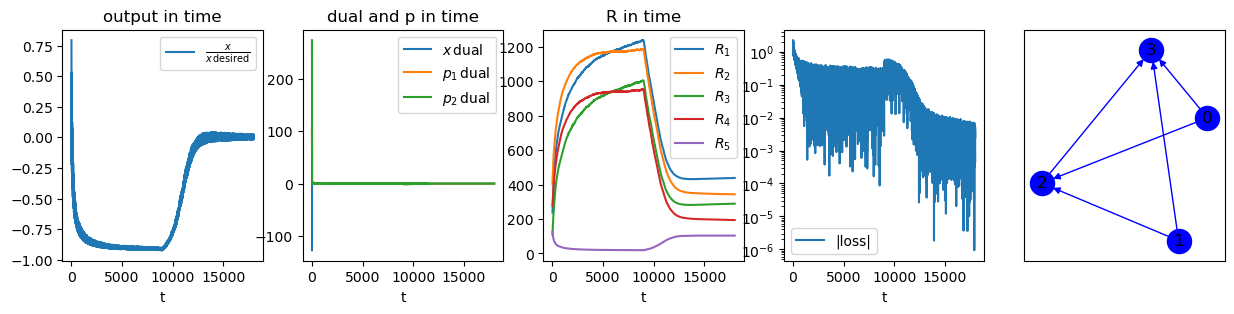

In [441]:
if hasattr(Variabs, 'M'):
    plot_functions.plot_importants(State, Variabs, State.desired_in_t, Variabs.M, include_network=True, NET=NET)
else:
    plot_functions.plot_importants(State, Variabs, State.desired_in_t, include_network=True)

In [443]:
State.R_in_t[-1]

array([438.06646877, 343.10662377, 288.78520357, 193.82535857,
       103.73708871])

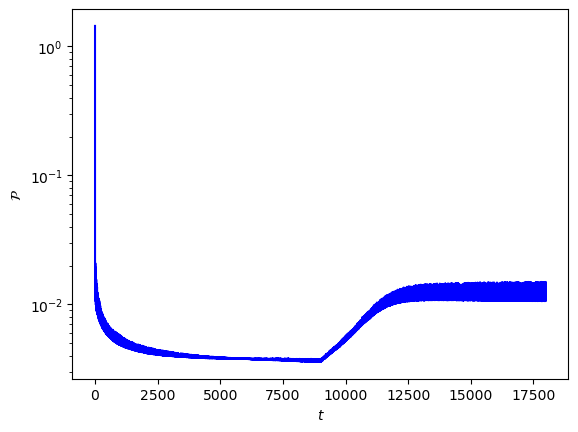

In [444]:
if np.size(State.Power_norm_in_t)>1:
    plot_functions.plot_Power(State)
else:
    pass

### accuracy

In [445]:
if task_type == 'Iris_classification':
    plot_functions.plot_accuracy(State.t, State.t_for_accuracy, State.accuracy_in_t, np.shape(Variabs.dataset)[0])
else:
    pass

In [446]:
# State.accuracy_in_t

In [447]:
State.output_in_t

[array([0.88350295]),
 array([0.5364442]),
 array([0.61863181]),
 array([0.61062317]),
 array([0.1378862]),
 array([0.13755739]),
 array([0.31722494]),
 array([0.31564384]),
 array([0.56020214]),
 array([0.55498583]),
 array([0.32258232]),
 array([0.32081547]),
 array([0.51243873]),
 array([0.50377723]),
 array([0.15135592]),
 array([0.15096824]),
 array([0.32025724]),
 array([0.31885956]),
 array([0.30967197]),
 array([0.30764331]),
 array([0.34871948]),
 array([0.34490305]),
 array([0.25479543]),
 array([0.25381028]),
 array([0.45963051]),
 array([0.45675904]),
 array([0.2500177]),
 array([0.24922356]),
 array([0.29511422]),
 array([0.29204036]),
 array([0.33299147]),
 array([0.32985934]),
 array([0.30981972]),
 array([0.30835061]),
 array([0.67397703]),
 array([0.66560461]),
 array([0.16222653]),
 array([0.16154285]),
 array([0.4245162]),
 array([0.42086445]),
 array([0.1923627]),
 array([0.19187199]),
 array([0.27058127]),
 array([0.26940814]),
 array([0.29474276]),
 array([0.29364

## Power of trained network

put a pressure of 1 through all inputs and measure total power dissipation in a trained network that has the state State

In [448]:
# Reload the module to reflect any changes made
importlib.reload(statistics)

# put pressure of 1 through inputs
State.input_drawn = np.ones(Nin)

# solve flow
State.solve_flow_given_problem(BigClass, "measure")

# measure power
print('u', State.u)
print('Rs', State.R_in_t[-1])
print('Power dissipation', statistics.power_dissip(State.u, State.R_in_t[-1]))

u [0.00148313 0.0018936  0.00346278 0.00515928 0.00337673]
Rs [438.06646877 343.10662377 288.78520357 193.82535857 103.73708871]
Power dissipation 0.011998794651453587


## Save sizes to file

In [449]:
save_folder_prelim = 'C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/'
        
# np.save(save_folder_prelim + 't_2in1out.npy', State.t)
# np.save(save_folder_prelim + 'M_2in1out.npy', M_values)
# np.save(save_folder_prelim + 'output_2in1out_RproptoDeltap.npy', np.asarray(State.output_in_t)/np.asarray(State.desired_in_t)-1)
# np.save(save_folder_prelim + 'input_dual_2in1out_RproptoDeltap.npy', State.input_dual_in_t)
# np.save(save_folder_prelim + 'output_dual_2in1out_RproptoDeltap.npy', State.output_dual_in_t)
# np.save(save_folder_prelim + 'R_2in1out_RproptoDeltap.npy', State.R_in_t)
# np.save(save_folder_prelim + 'loss_2in1out_RproptoDeltap.npy', State.loss_in_t)

# import pickle
# # NET.NET networkx graph
# with open(save_folder_prelim + 'NETgraph_1in2out.pkl', 'wb') as f:
#     pickle.dump(NET.NET, f)
    
# # Save the dictionary to a file
# with open(save_folder_prelim + 'pos_lattice_1in2out.pkl', 'wb') as f:
#     pickle.dump(NET.pos_lattice, f)
      
# np.save(save_folder_prelim + 'output_2in1out.npy', np.asarray(State.output_in_t)/np.asarray(State.desired_in_t)-1)
# np.save(save_folder_prelim + 'input_dual_2in1out.npy', State.input_dual_in_t)
# np.save(save_folder_prelim + 'output_dual_2in1out.npy', State.output_dual_in_t)
# np.save(save_folder_prelim + 'R_2in1out.npy', State.R_in_t)
# np.save(save_folder_prelim + 'loss_2in1out.npy', State.loss_in_t)

# import pickle
# # NET.NET networkx graph
# with open(save_folder_prelim + 'NETgraph_2in1out.pkl', 'wb') as f:
#     pickle.dump(NET.NET, f)
    
# # Save the dictionary to a file
# with open(save_folder_prelim + 'pos_lattice_2in1out.pkl', 'wb') as f:
#     pickle.dump(NET.pos_lattice, f)

# loss_mat = np.array([[6.00E-05, 1.20E-03, 2.20E-03, 7.20E-03],[5.00E-05, 0.12, 0.16, 0.15], [2.00E-05, 0.18, 0.16, 0.13], [1.10E-03, 0.049, 0.09, 2.6]])
# np.save(save_folder_prelim + 'loss_mat.npy', loss_mat)

### Loss afo inputs and outputs

In [450]:
load_folder_prelim = 'C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.8/27Aug/'

loss_mat = np.load(load_folder_prelim + 'loss_mat.npy')

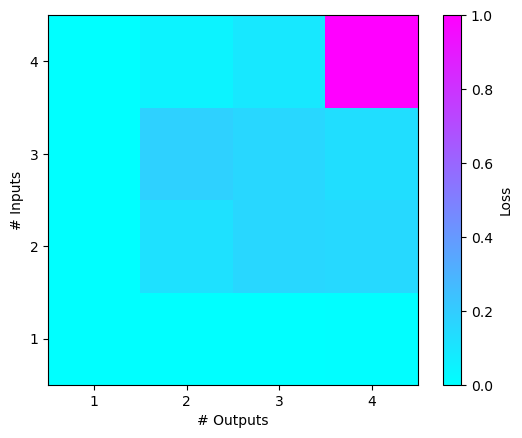

In [451]:
# Reload the module to reflect any changes made
importlib.reload(figure_plots)

figure_plots.loss_afo_in_out(loss_mat)

### R change scheme under 2 tasks

In [452]:
import pickle

load_folder_prelim = 'C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/importants_1in2out_n_2in1out/'

t = np.load(load_folder_prelim + 't_1in2out.npy')

loss_1in2out_R_propto_deltap = np.load(load_folder_prelim + 'loss_1in2out_RproptoDeltap.npy')
loss_1in2out_deltaR_propto_deltap = np.load(load_folder_prelim + 'loss_1in2out_deltaRproptoDeltap.npy')
loss_1in2out_propto_Q = np.load(load_folder_prelim + 'loss_1in2out_deltaRproptoQ.npy')
loss_1in2out_propto_Power = np.load(load_folder_prelim + 'loss_1in2out_deltaRproptoPower.npy')
loss_2in1out_R_propto_deltap = np.load(load_folder_prelim + 'loss_2in1out_RproptoDeltap.npy')
loss_2in1out_deltaR_propto_deltap = np.load(load_folder_prelim + 'loss_2in1out_deltaRproptoDeltap.npy')
loss_2in1out_propto_Q = np.load(load_folder_prelim + 'loss_2in1out_deltaRproptoQ.npy')
loss_2in1out_propto_Power = np.load(load_folder_prelim + 'loss_2in1out_deltaRproptoPower.npy')

with open(load_folder_prelim + 'NETgraph_1in2out.pkl', 'rb') as f:
    Network_1in2out = pickle.load(f)
    
with open(load_folder_prelim + 'NETgraph_2in1out.pkl', 'rb') as f:
    Network_2in1out = pickle.load(f)
    
with open(load_folder_prelim + 'pos_lattice_2in1out.pkl', 'rb') as f:
    pos_lattice = pickle.load(f) 

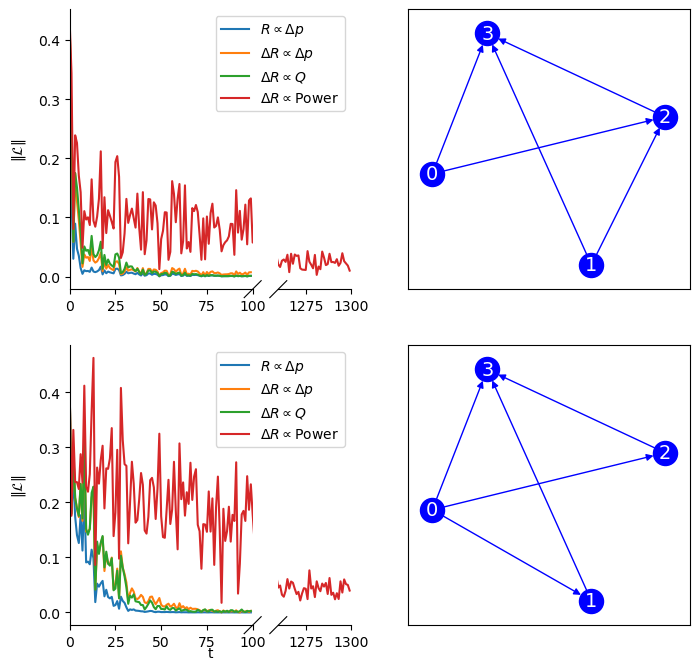

In [453]:
# Reload the module to reflect any changes made
importlib.reload(figure_plots)

figure_plots.plot_compare_R_type_loss(Network_1in2out, Network_2in1out, pos_lattice,
                         loss_1in2out_R_propto_deltap,
                         loss_1in2out_deltaR_propto_deltap,
                         loss_1in2out_propto_Q,
                         loss_1in2out_propto_Power,
                         loss_2in1out_R_propto_deltap,
                         loss_2in1out_deltaR_propto_deltap,
                         loss_2in1out_propto_Q,
                         loss_2in1out_propto_Power)

### 2 Network examples

In [454]:
import pickle

load_folder_prelim = 'C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/inner_variables_2examples/'

t = np.load(load_folder_prelim + 't.npy')
M = np.load(load_folder_prelim + 'M.npy')

output_1in2out = np.load(load_folder_prelim + 'output_1in2out.npy')
input_dual_1in2out = np.load(load_folder_prelim + 'input_dual_1in2out.npy')
output_dual_1in2out = np.load(load_folder_prelim + 'output_dual_1in2out.npy')
R_1in2out = np.load(load_folder_prelim + 'R_1in2out.npy')
loss_1in2out = np.load(load_folder_prelim + 'loss_1in2out.npy')

output_2in1out = np.load(load_folder_prelim + 'output_2in1out.npy')
input_dual_2in1out = np.load(load_folder_prelim + 'input_dual_2in1out.npy')
output_dual_2in1out = np.load(load_folder_prelim + 'output_dual_2in1out.npy')
R_2in1out = np.load(load_folder_prelim + 'R_2in1out.npy')
loss_2in1out = np.load(load_folder_prelim + 'loss_2in1out.npy')
with open(load_folder_prelim + 'NETgraph_1in2out.pkl', 'rb') as f:
    NET_1in2out = pickle.load(f)
    
with open(load_folder_prelim + 'pos_lattice_1in2out.pkl', 'rb') as f:
    pos_lattice_1in2out = pickle.load(f)
    
with open(load_folder_prelim + 'NETgraph_2in1out.pkl', 'rb') as f:
    NET_2in1out = pickle.load(f)
    
with open(load_folder_prelim + 'pos_lattice_2in1out.pkl', 'rb') as f:
    pos_lattice_2in1out = pickle.load(f)    

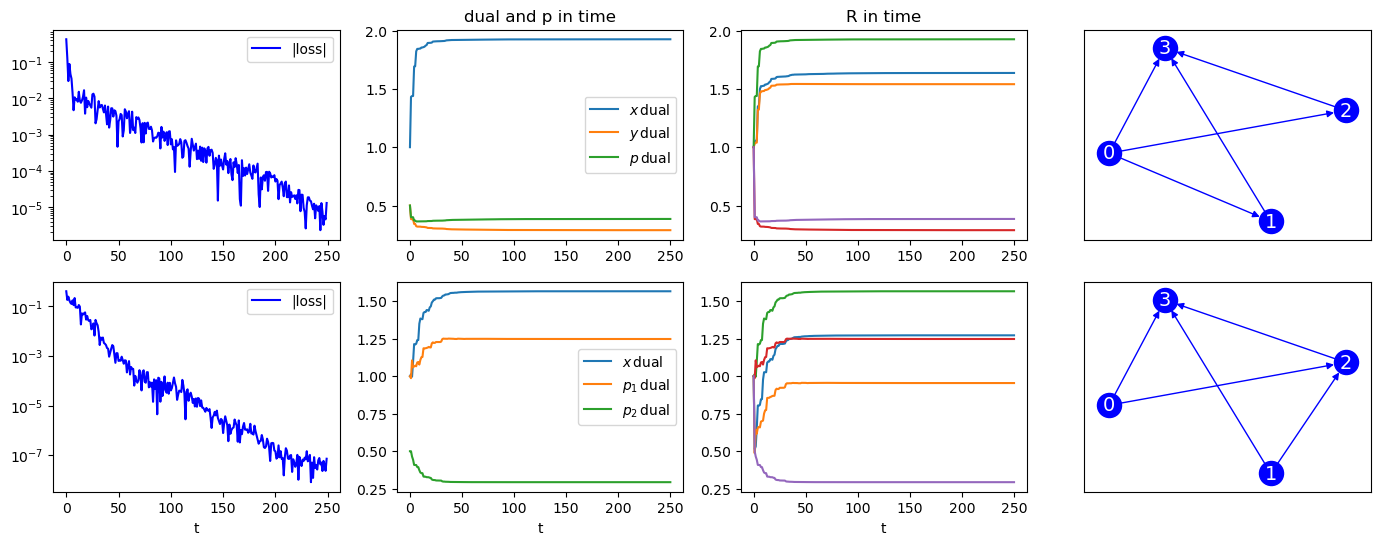

In [455]:
# Reload the module to reflect any changes made
importlib.reload(figure_plots)

figure_plots.plot_performance_2(M, t, output_1in2out, output_2in1out, input_dual_1in2out, input_dual_2in1out, 
                                  output_dual_1in2out, output_dual_2in1out, R_1in2out, R_2in1out, loss_1in2out, loss_2in1out,
                                  NET_1in2out, NET_2in1out, pos_lattice_1in2out, pos_lattice_2in1out)

### different R relations

In [456]:
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/R_propto_deltap.npy', R_propto_deltap)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/deltaR_propto_deltap.npy', deltaR_propto_deltap)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/deltaR_propto_Q.npy', deltaR_propto_Q)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/deltaR_propto_Power.npy', deltaR_propto_Power)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/loss_R_propto_deltap.npy', loss_R_propto_deltap)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/loss_deltaR_propto_deltap.npy', loss_deltaR_propto_deltap)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/loss_propto_Q.npy', loss_propto_Q)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/loss_propto_Power.npy', loss_propto_Power)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/t_final.npy', State.t)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/t_for_accuracy.npy', State.t_for_accuracy)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/accuracy.npy', State.accuracy_in_t)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/dataset_len.npy', np.shape(Variabs.dataset)[0])

In [457]:
# Loading the array later
R_propto_deltap = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/R_propto_deltap.npy')
deltaR_propto_deltap = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/deltaR_propto_deltap.npy')
deltaR_propto_Q = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/deltaR_propto_Q.npy')
deltaR_propto_Power = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/deltaR_propto_Power.npy')
loss_R_propto_deltap = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/loss_R_propto_deltap.npy')
loss_deltaR_propto_deltap = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/loss_deltaR_propto_deltap.npy')
loss_propto_Q = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/loss_propto_Q.npy')
loss_propto_Power = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/loss_propto_Power.npy')

In [458]:
# Reload the module to reflect any changes made
importlib.reload(plot_functions)

<module 'plot_functions' from 'C:\\Users\\SMR_Admin\\OneDrive - huji.ac.il\\PhD\\Network Simulation repo\\Network combine\\Network_combine\\plot_functions.py'>

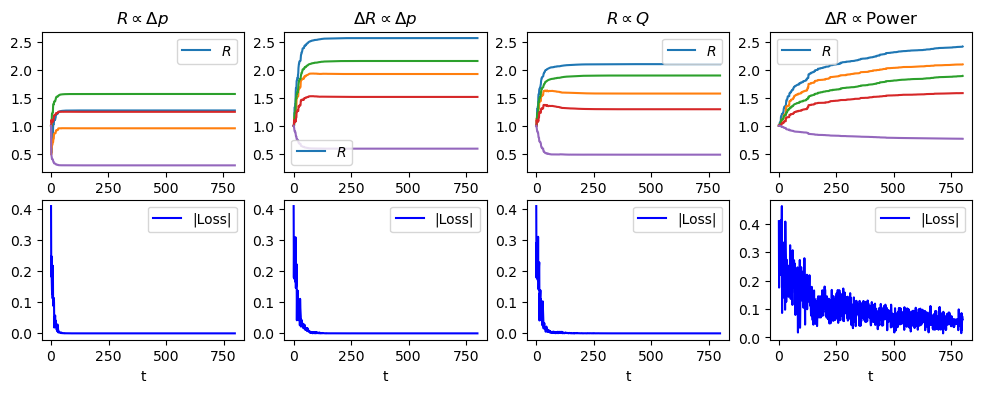

In [459]:
figure_plots.plot_comparison_R_type(R_propto_deltap, deltaR_propto_deltap, deltaR_propto_Q, deltaR_propto_Power,
                                      loss_R_propto_deltap, loss_deltaR_propto_deltap, loss_propto_Q, loss_propto_Power)

### pseudo vs. network comparison

In [460]:
# R_in_t_network = State.R_in_t
# R_in_t_pseudo = State.R_in_t
# loss_network = State.loss_in_t
# loss_pseudo = State.loss_in_t

In [461]:
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/R_in_t_network.npy', R_in_t_network)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/R_in_t_pseudo.npy', R_in_t_pseudo)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/loss_in_t_network.npy', loss_network)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/loss_in_t_pseudo.npy', loss_pseudo)

In [462]:
# Loading the array later
R_in_t_network = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.8/30Aug_R_pseudo_vs_network/R_in_t_network.npy')
R_in_t_pseudo = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.8/30Aug_R_pseudo_vs_network/R_in_t_pseudo.npy')
loss_in_t_network = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.8/30Aug_R_pseudo_vs_network/loss_in_t_network.npy')
loss_in_t_pseudo = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.8/30Aug_R_pseudo_vs_network/loss_in_t_pseudo.npy')

In [463]:
# Reload the module to reflect any changes made
importlib.reload(plot_functions)

<module 'plot_functions' from 'C:\\Users\\SMR_Admin\\OneDrive - huji.ac.il\\PhD\\Network Simulation repo\\Network combine\\Network_combine\\plot_functions.py'>

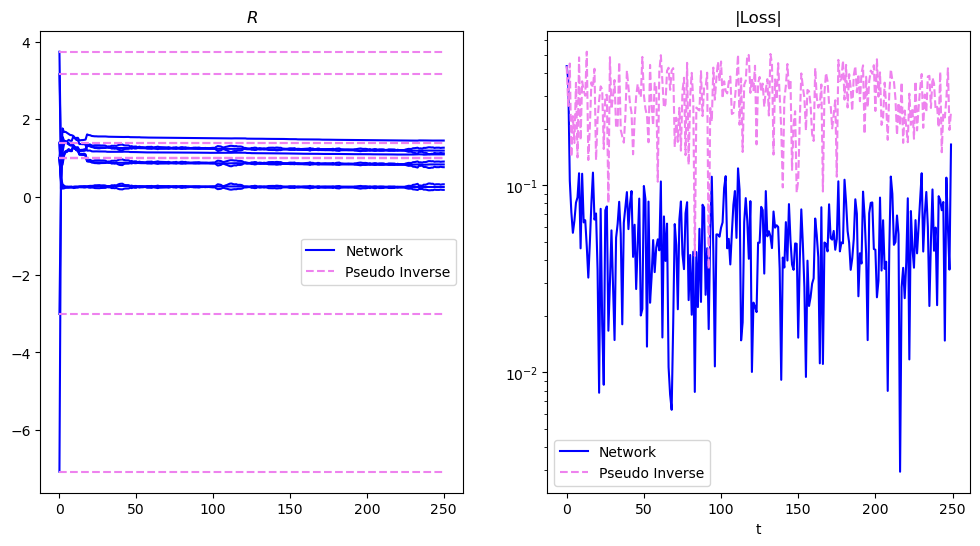

In [464]:
figure_plots.plot_comparison_pseudo(R_in_t_pseudo, R_in_t_network, loss_in_t_pseudo, loss_in_t_network)

In [465]:
t_final = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/accuracy_pt8/t_final.npy')
t_for_accuracy = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/accuracy_pt8/t_for_accuracy.npy')
accuracy_in_t = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/accuracy_pt8/accuracy.npy')
dataset_len = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/accuracy_pt8/dataset_len.npy')

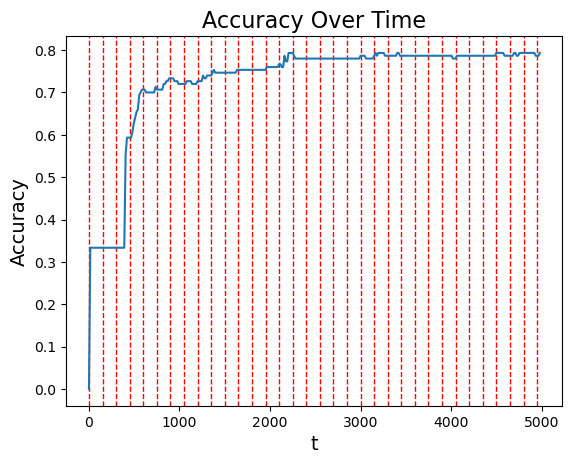

In [466]:
plot_functions.plot_accuracy(t_final, t_for_accuracy, accuracy_in_t, dataset_len)

## Statistics

### Error

In [467]:
final_err = statistics.final_err(BigClass, 40)
print('final_err', final_err)

final_err 0.007881884307792806


## Checks

In [468]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.utils import shuffle
from numpy.linalg import norm

In [469]:
# Load the Iris dataset
iris = load_iris()
dataset, numerical_targets = shuffle(iris['data'], iris['target'], random_state=42)
# Min-Max Scale dataset to [0, 4]
min_max_scaler = MinMaxScaler(feature_range=(0, 4))
dataset = min_max_scaler.fit_transform(dataset)
# One-hot encode the label
encoder = OneHotEncoder(sparse_output=False, categories='auto')
targets_reshaped = numerical_targets.reshape(-1, 1)  # Reshape for the encoder
targets = encoder.fit_transform(targets_reshaped)